In [1]:
# from tqdm import tqdm
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

In [3]:
# from datasets import Myloader
# from networks_pyg.init import init_model
# from utils.utils import get_congestion_start_end

In [2]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
# filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]

## load accident_all
accident_all = pd.read_csv('data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of all Events, # of sids =  4203 15629
# of filtered Events =  849


In [5]:
accident_all['accident_sid'].value_counts()

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
              ..
2210066900     1
1120013402     1
1100005401     1
1070010402     1
1040020100     1
Name: accident_sid, Length: 482, dtype: int64

In [6]:
    target_sid = 1210005301 ## 1030001902    ## 1210005301
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    normalize = 'standard'

    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

#         df_all_norm = df_all_norm.rolling(3).mean()

#     # define anomaly label
#     labels = []
#     accident_case['created'] = pd.to_datetime(accident_case['created'])
#     for ix, row in accident_case.iterrows():
#         accident_created = row['created']
#         min = accident_created.minute % 5
#         sec = accident_created.second
#         accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
#         labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
#     labels = list(map(int, (np.sum(labels, axis=0) > 0)))
#     label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])

## Normal Data

In [8]:
rolling_window = 3
df_all_norm = df_all_norm.rolling(rolling_window).mean()
df_all_norm = df_all_norm.iloc[rolling_window-1:]

In [9]:
path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

In [10]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    df_agg_inflow.append(df_all_norm[inflow].mean(axis=1))
    df_agg_outflow.append(df_all_norm[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

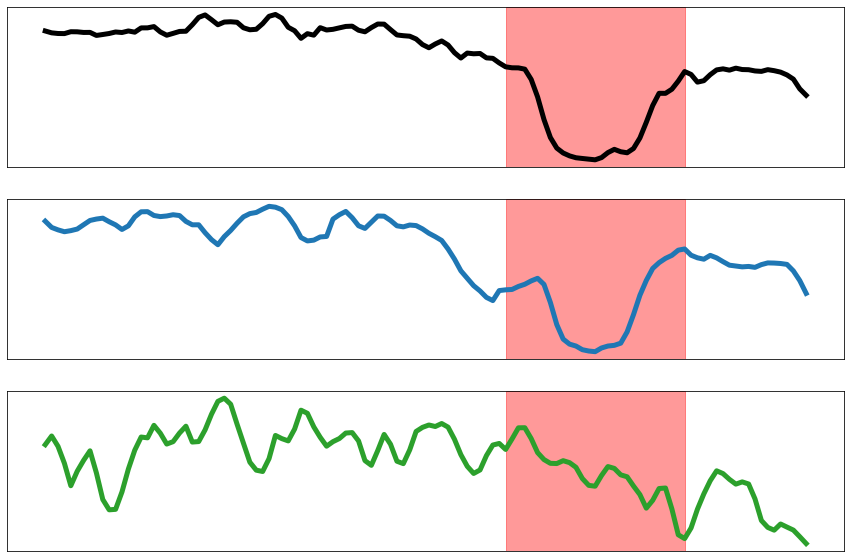

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
ax[0].plot(df_all_norm[580:700][accident_sid], color='k', lw=5)
ax[1].plot(df_agg_inflow[580:700][1], lw=5)
ax[2].plot(df_agg_outflow[580:700][1], color='tab:green', lw=5)
for i in range(3):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].axvspan(df_all_norm.index[652], df_all_norm.index[680], color='r', alpha=0.4)

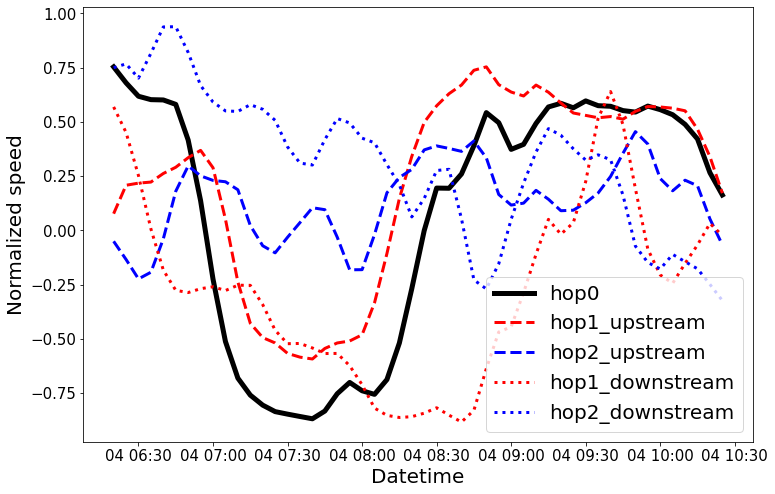

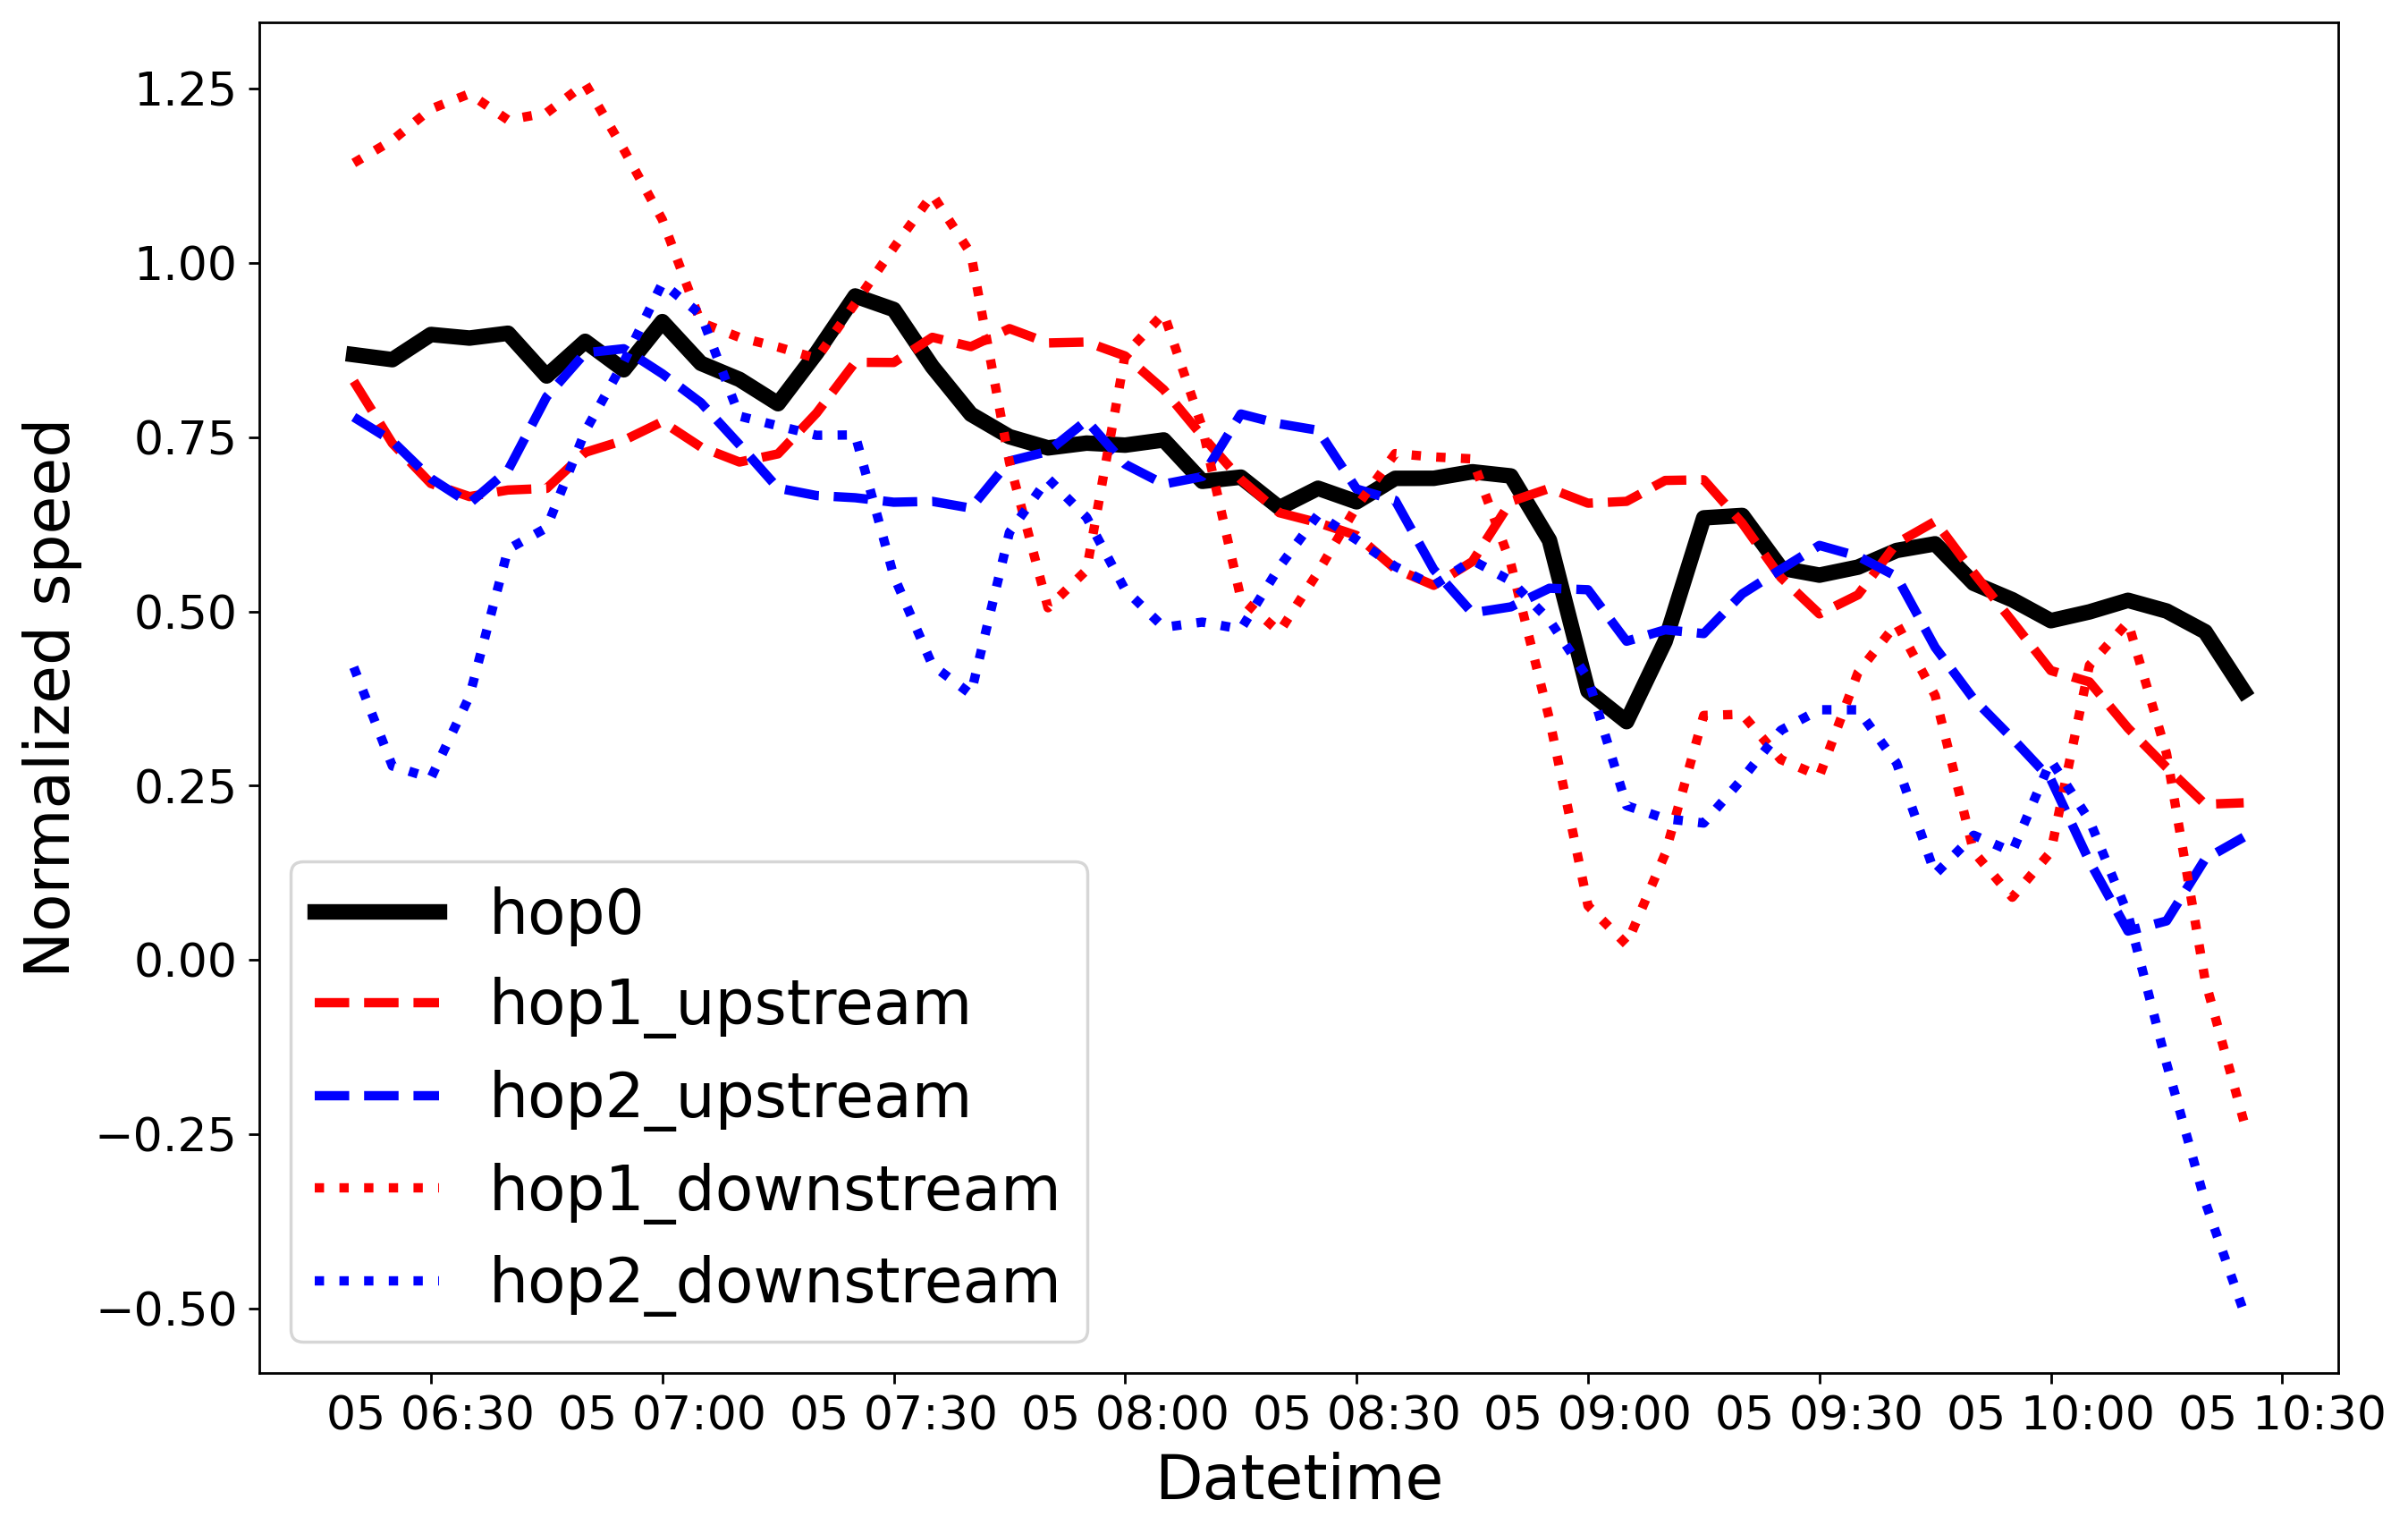

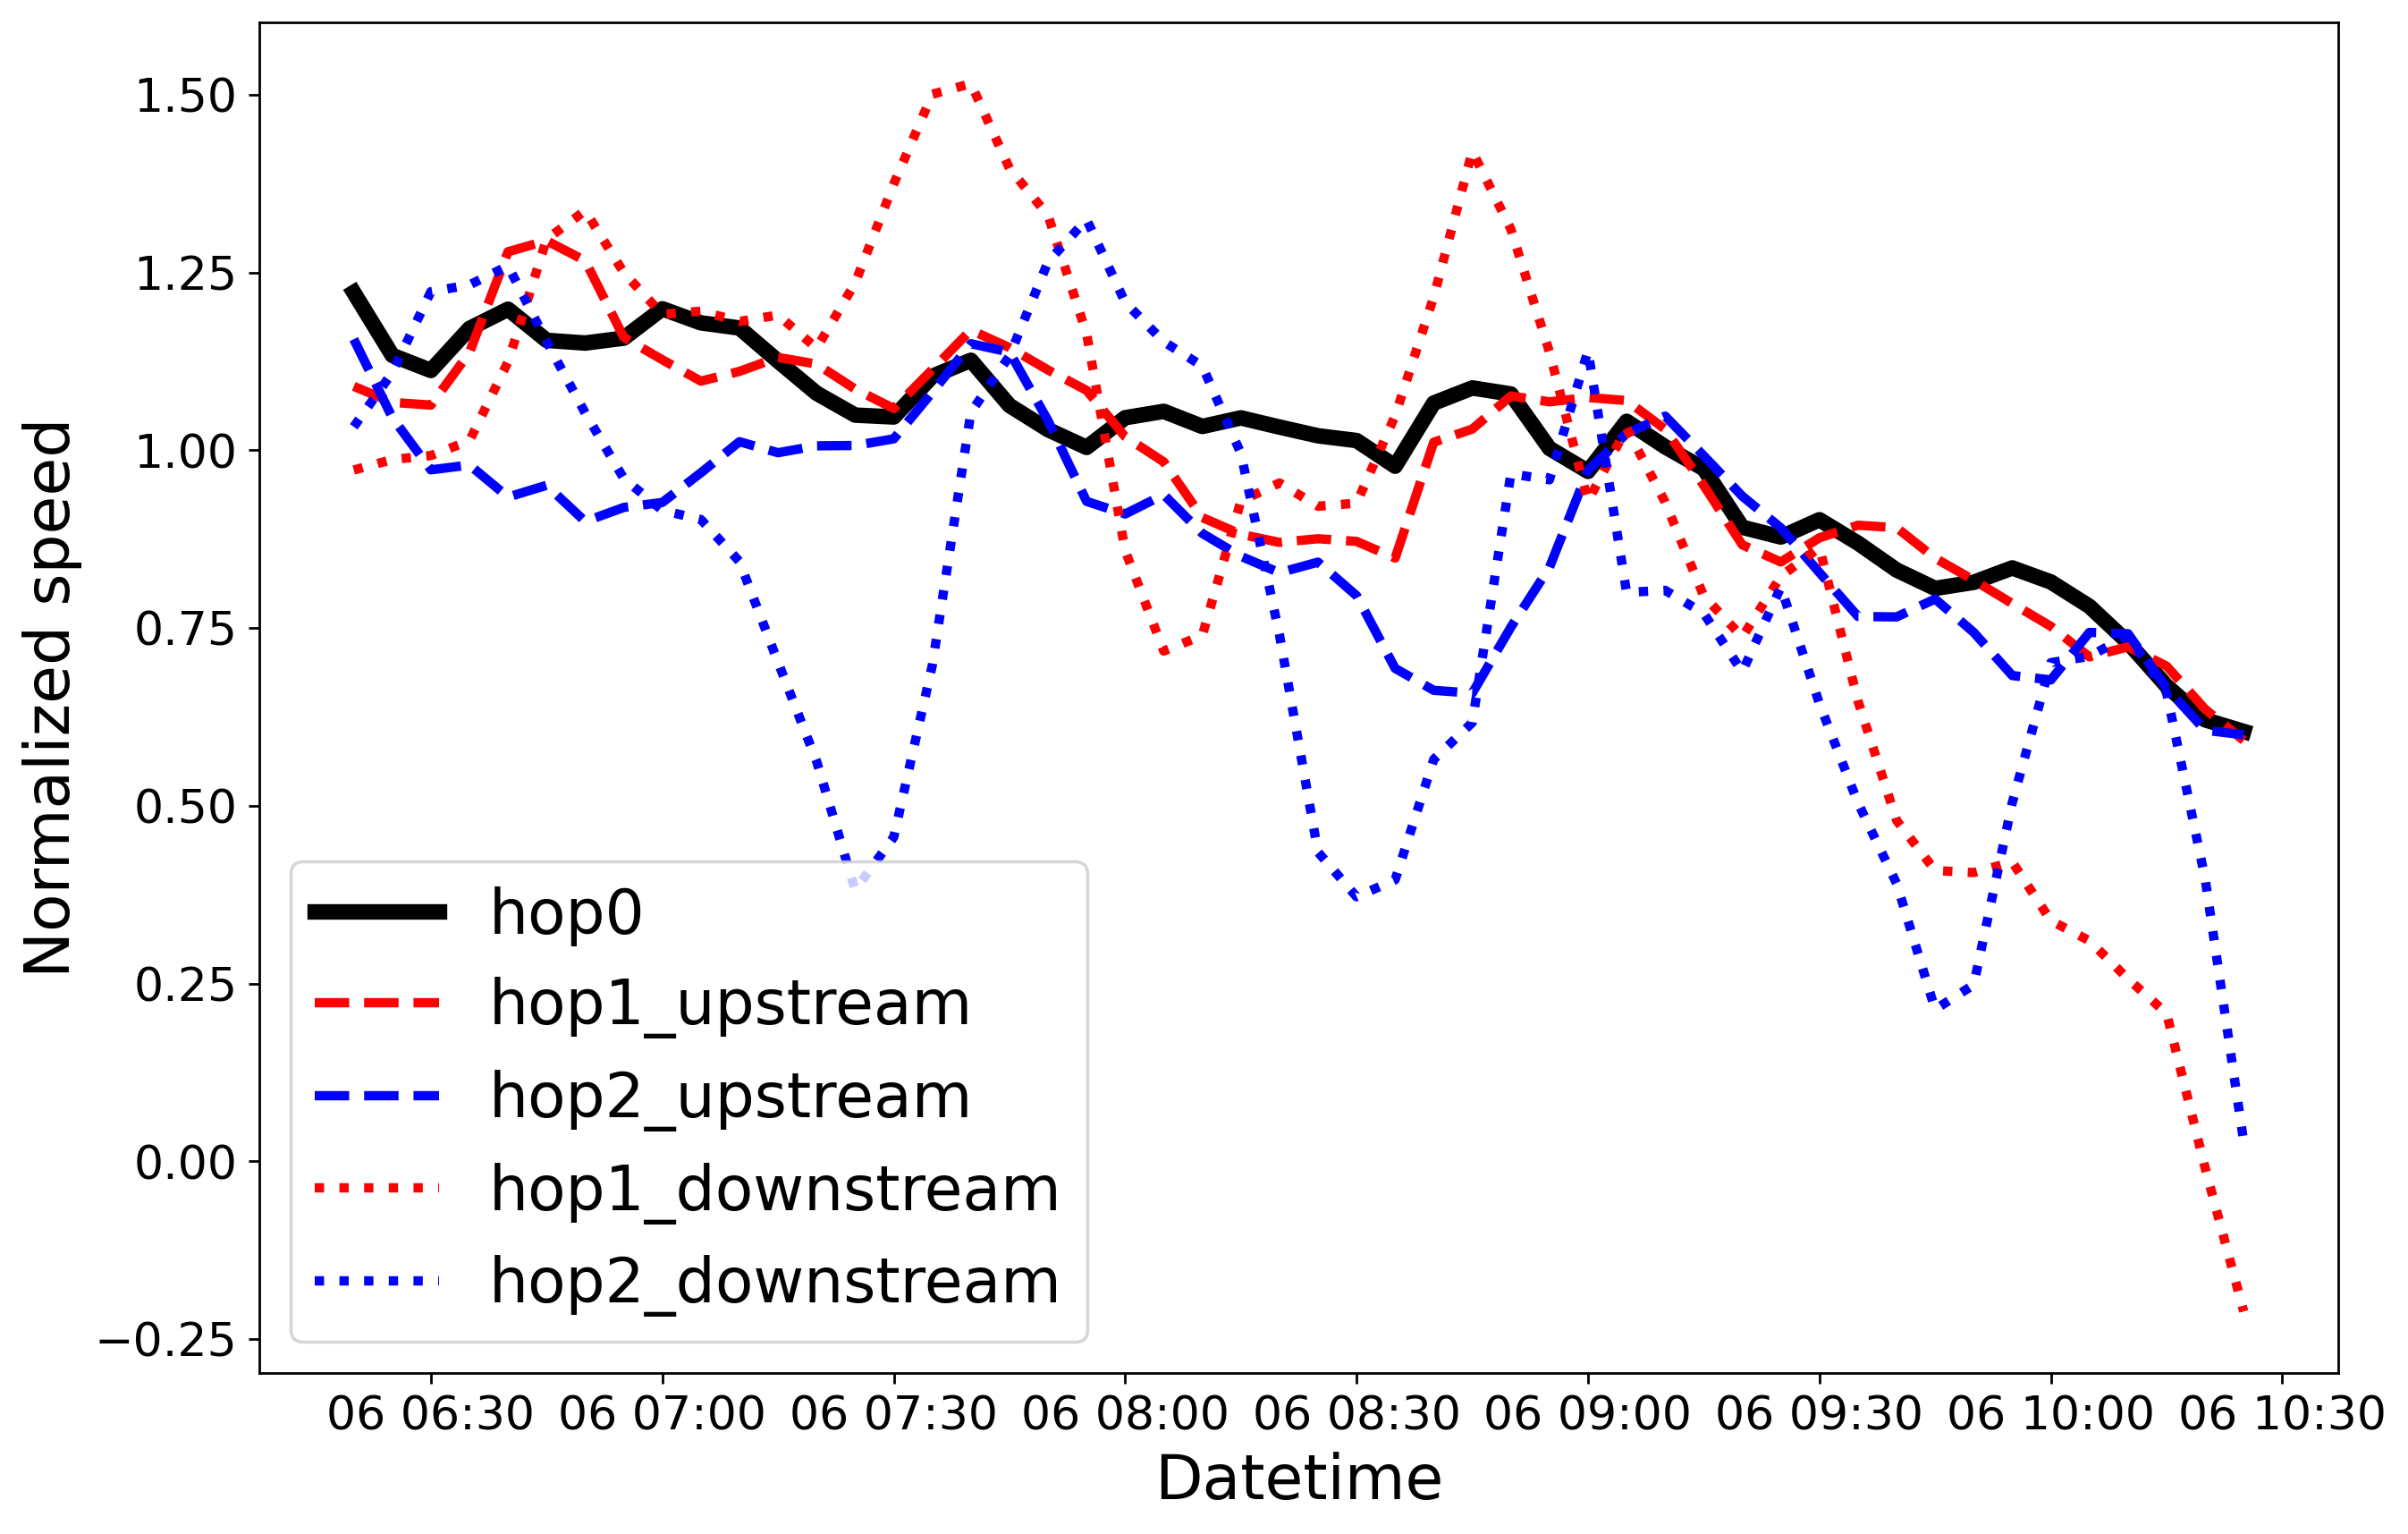

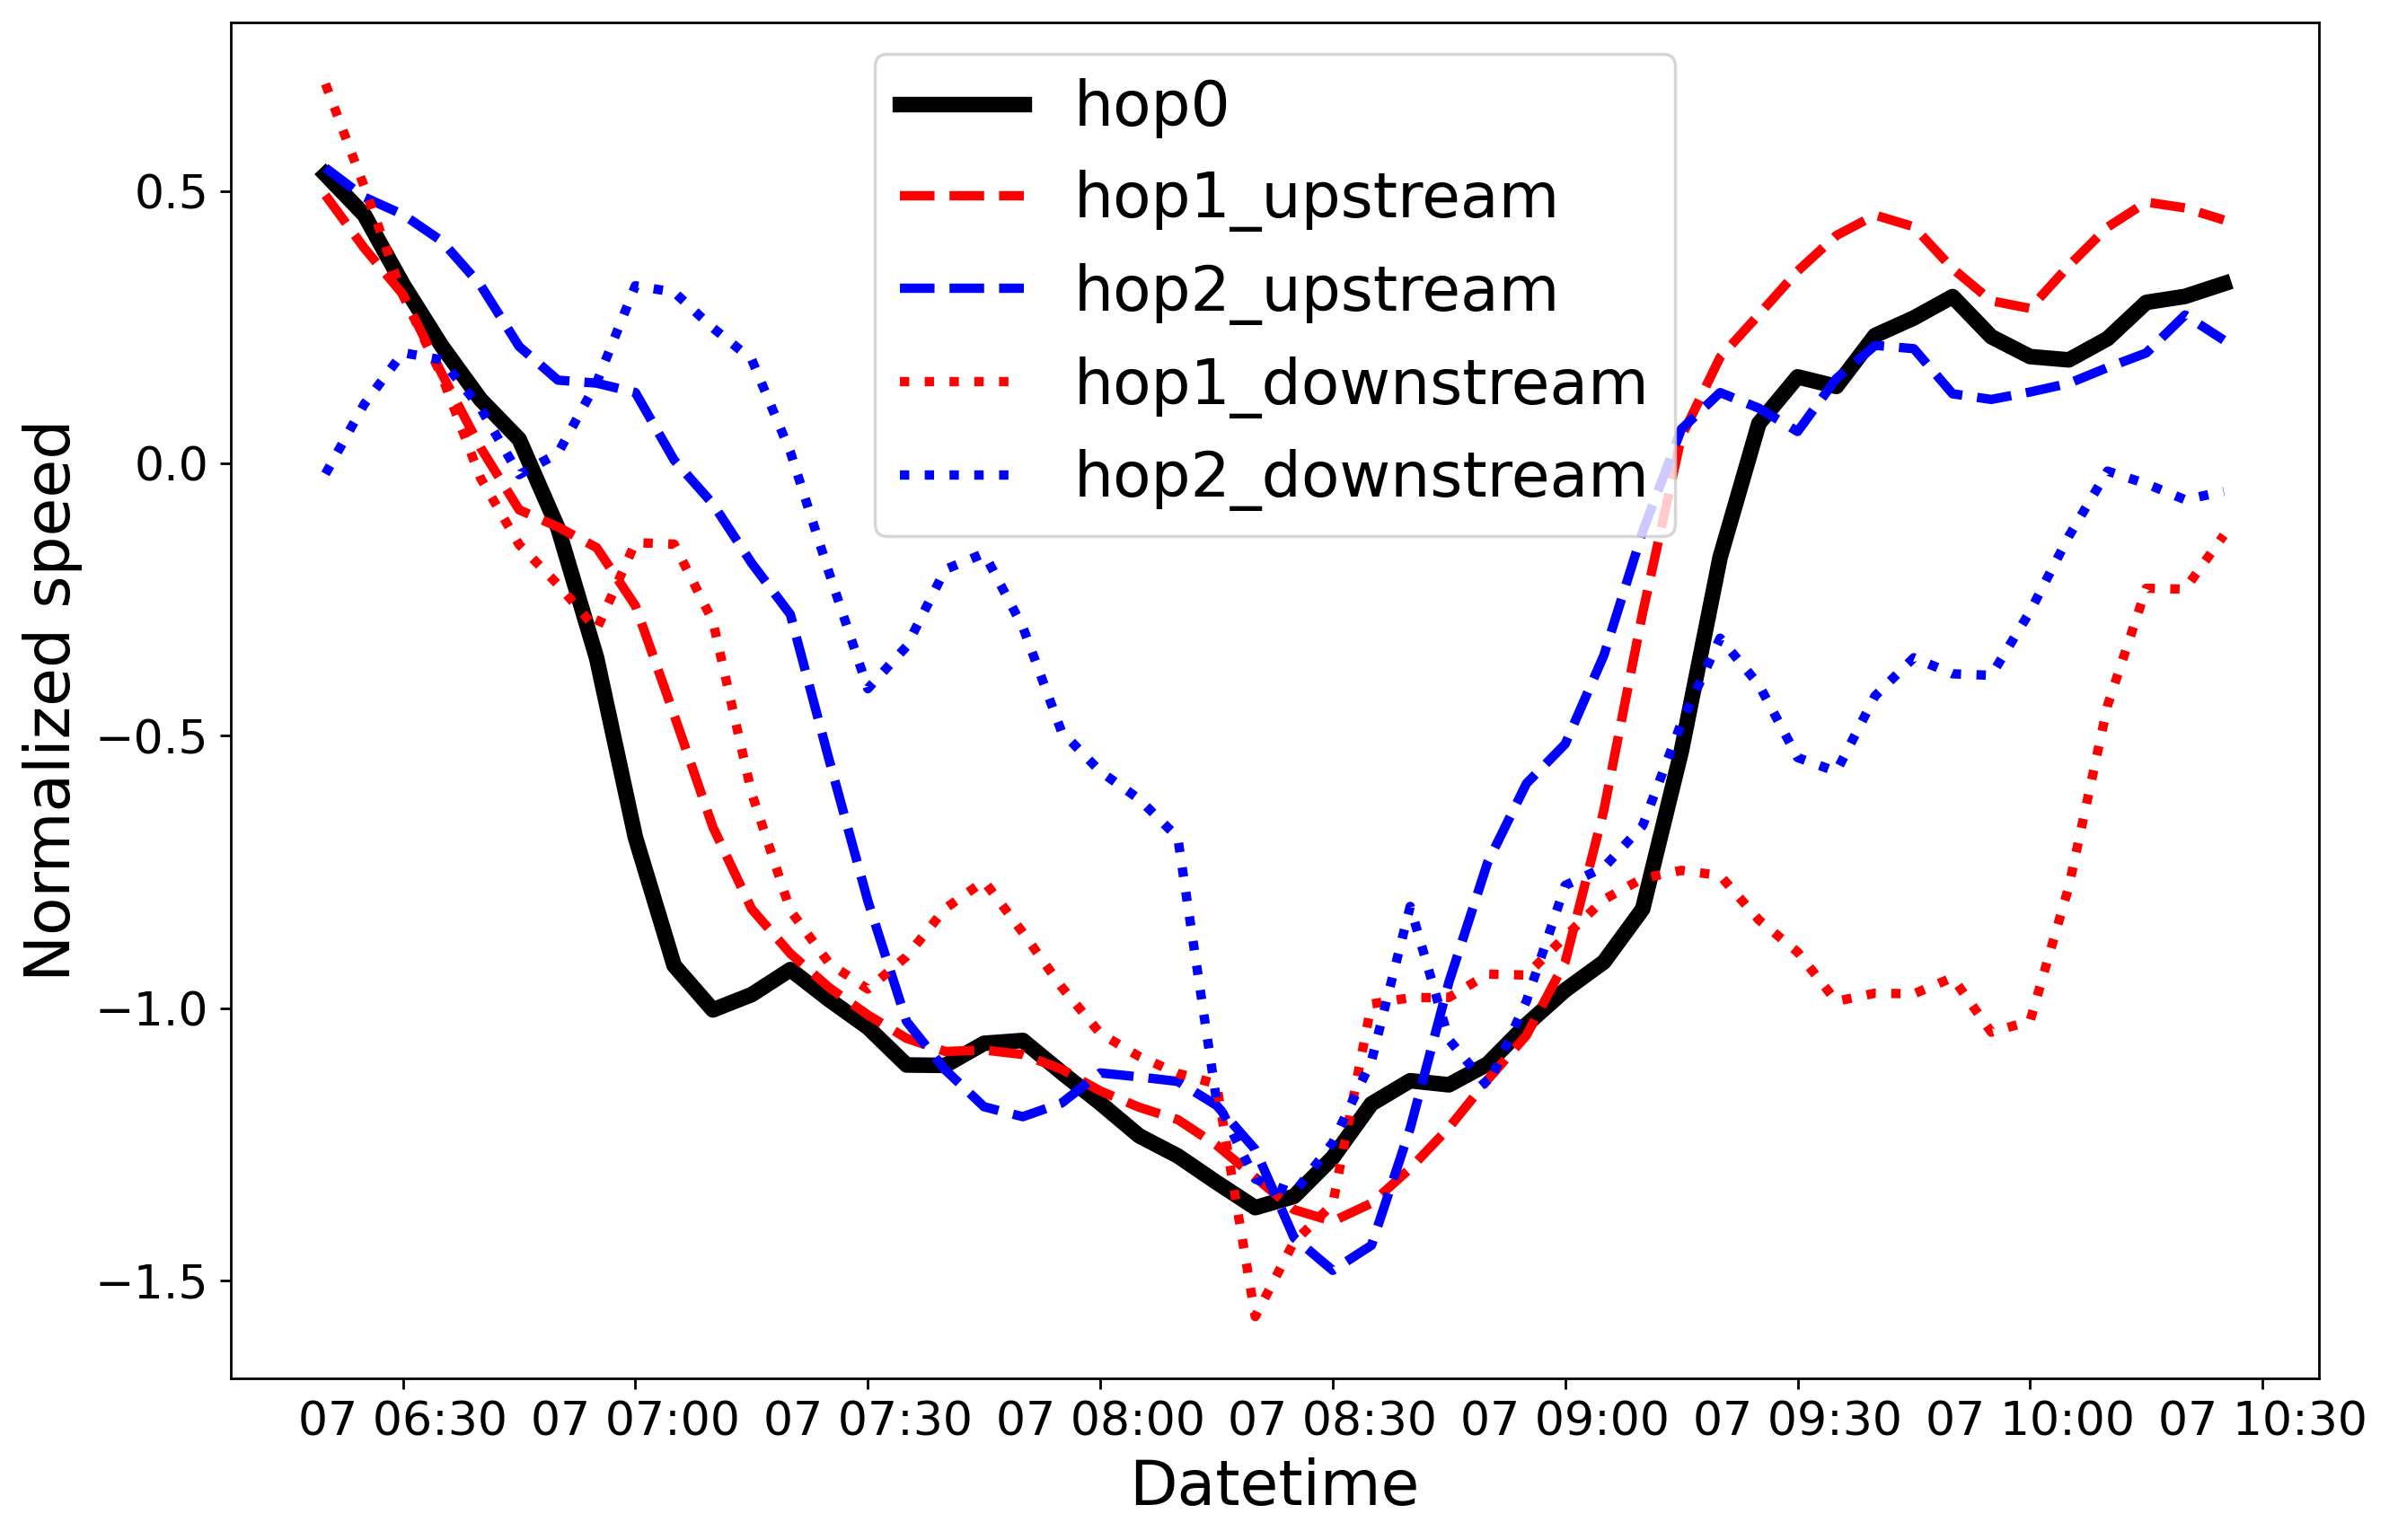

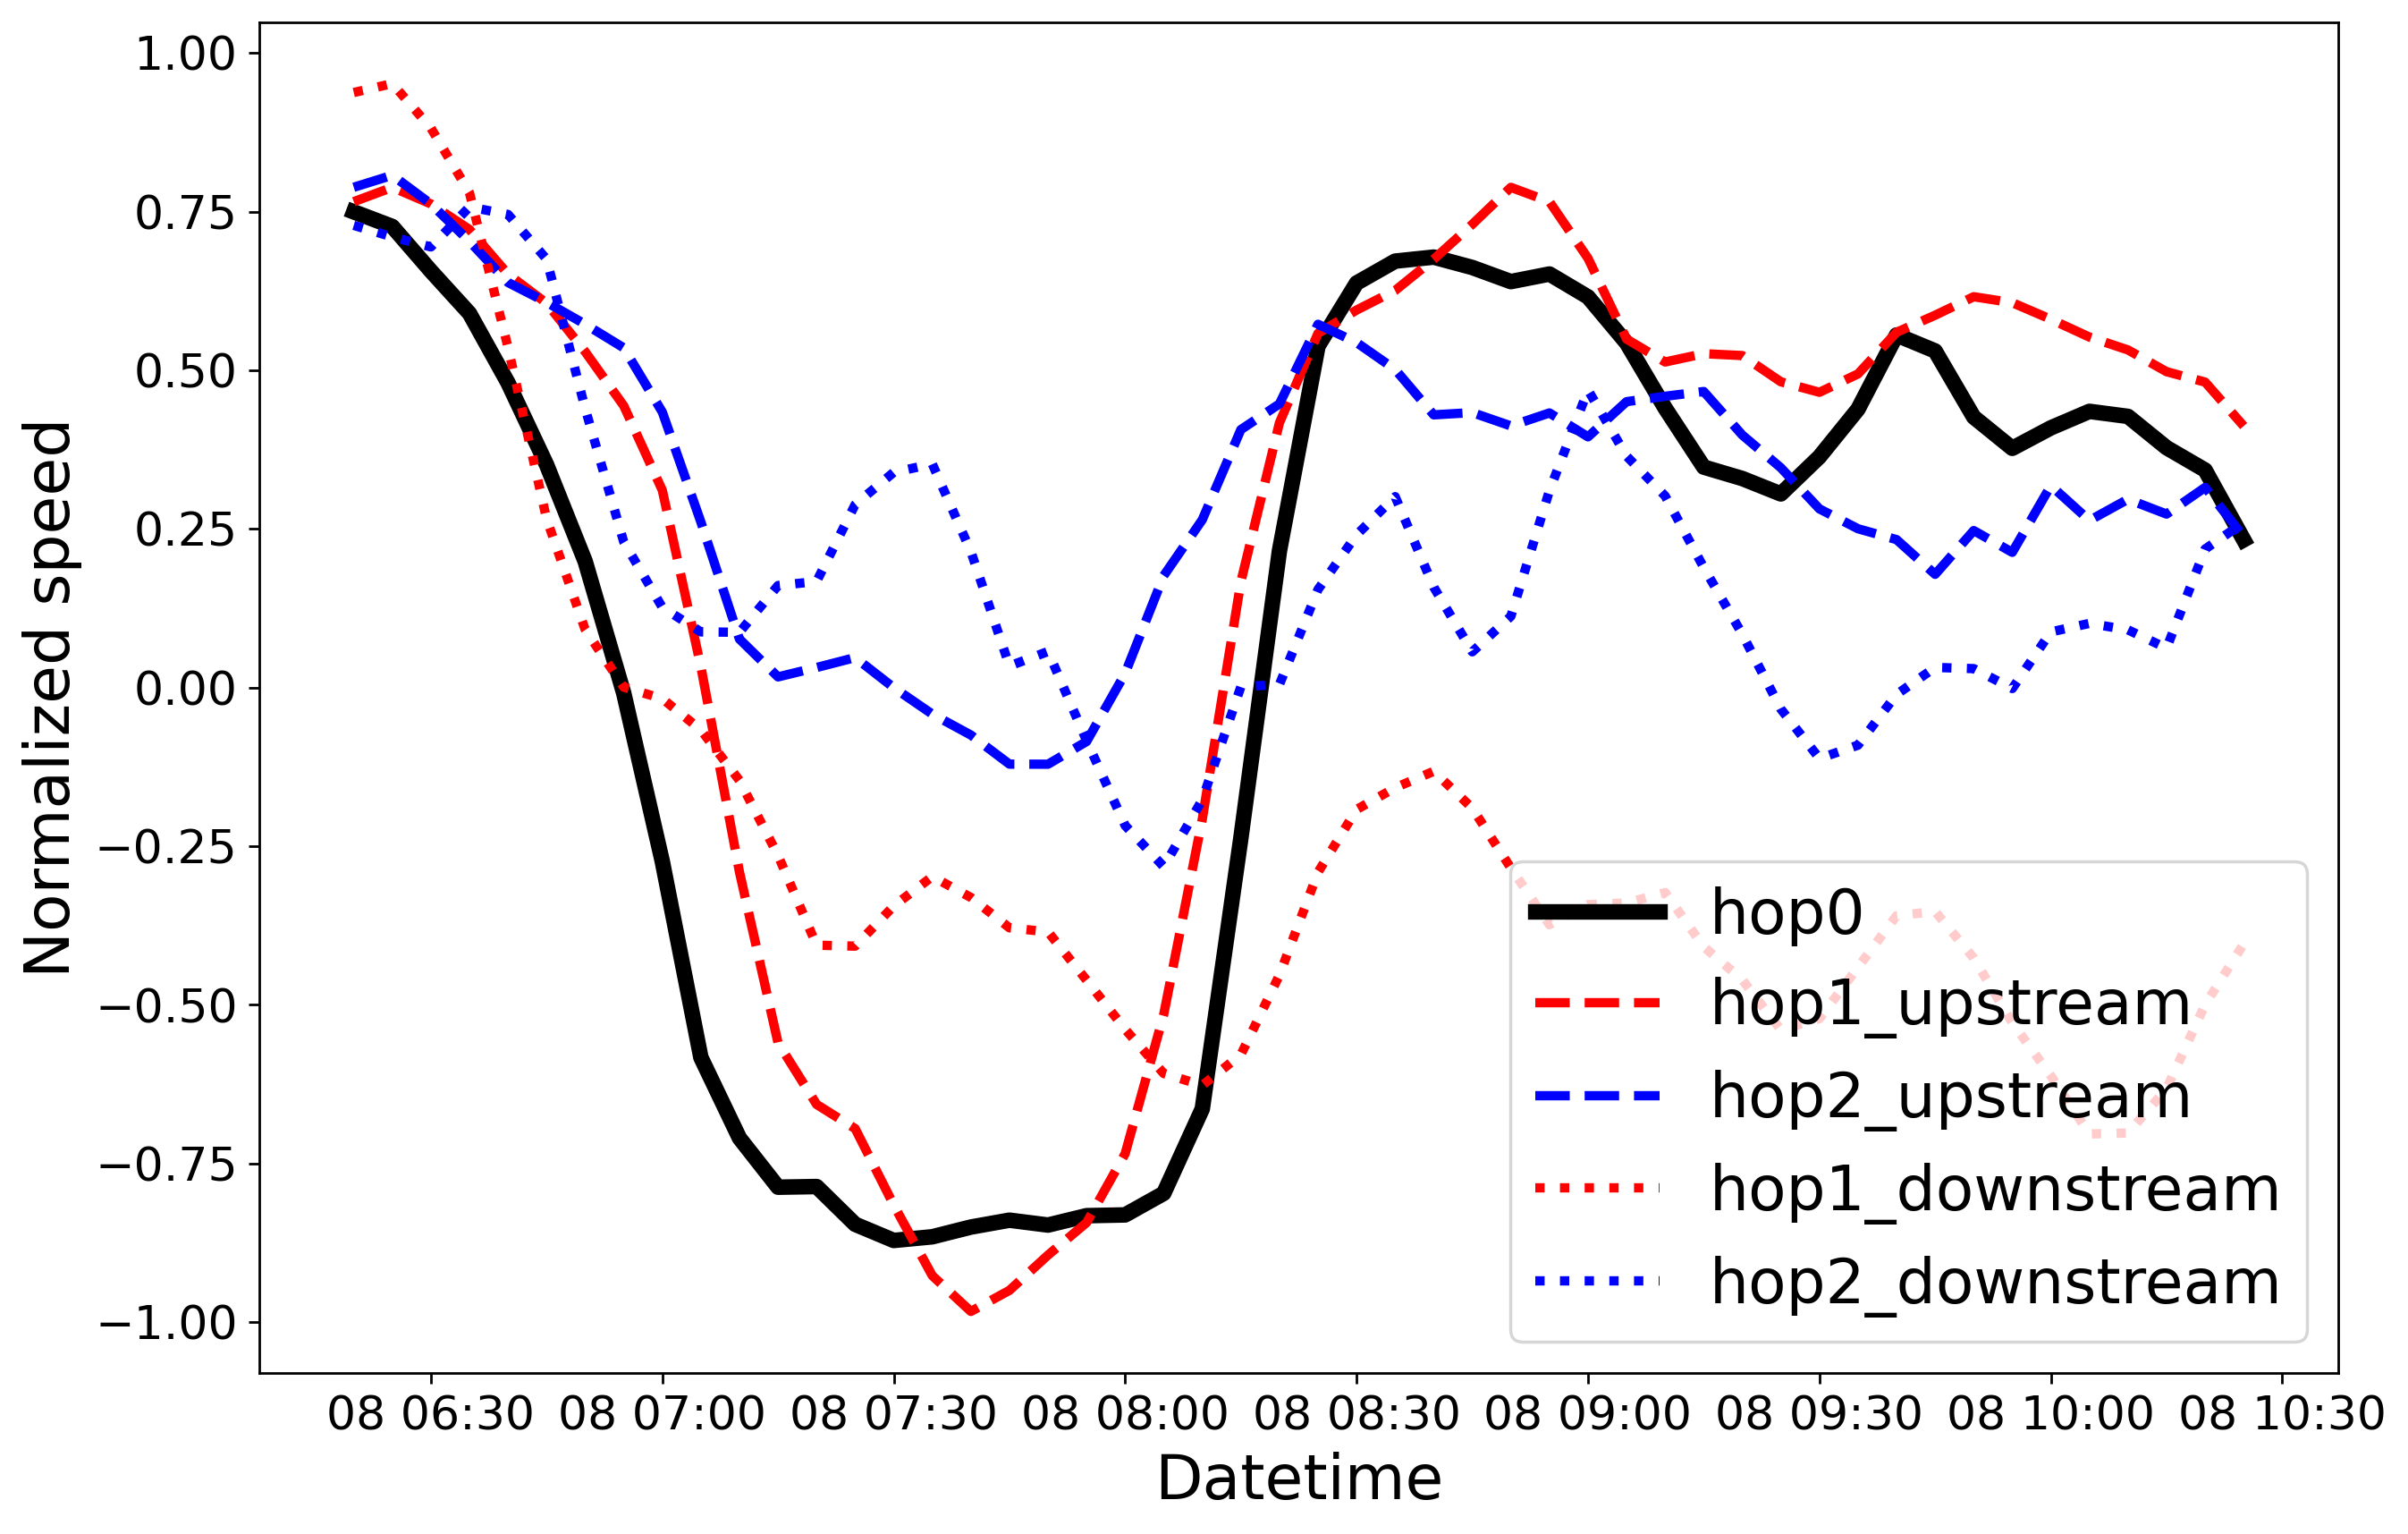

In [12]:
for i in range(5):
    t0 = 650 + 288*i
    t1 = 700 + 288*i
    plt.figure(figsize=(12, 8))
    plt.plot(df_agg_inflow.iloc[t0:t1][0], label='hop0', lw=5, color='k', ls='solid')
    plt.plot(df_agg_inflow[t0:t1][1], label='hop1_upstream', lw=3, ls='dashed', color='r')
    plt.plot(df_agg_inflow[t0:t1][2], label='hop2_upstream', lw=3, ls='dashed', color='b')
    plt.plot(df_agg_outflow[t0:t1][2], label='hop1_downstream', lw=3, ls='dotted', color='r')
    plt.plot(df_agg_outflow[t0:t1][1], label='hop2_downstream', lw=3, ls='dotted', color='b')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(prop={'size':20})
    # plt.title('Recurrent Congestion Example', size=18)
    plt.xlabel('Datetime', size=20)
    plt.ylabel('Normalized speed', size=20)
    plt.legend(fontsize=20)
    
    plt.rcParams['figure.dpi'] = 250
    plt.show()
    

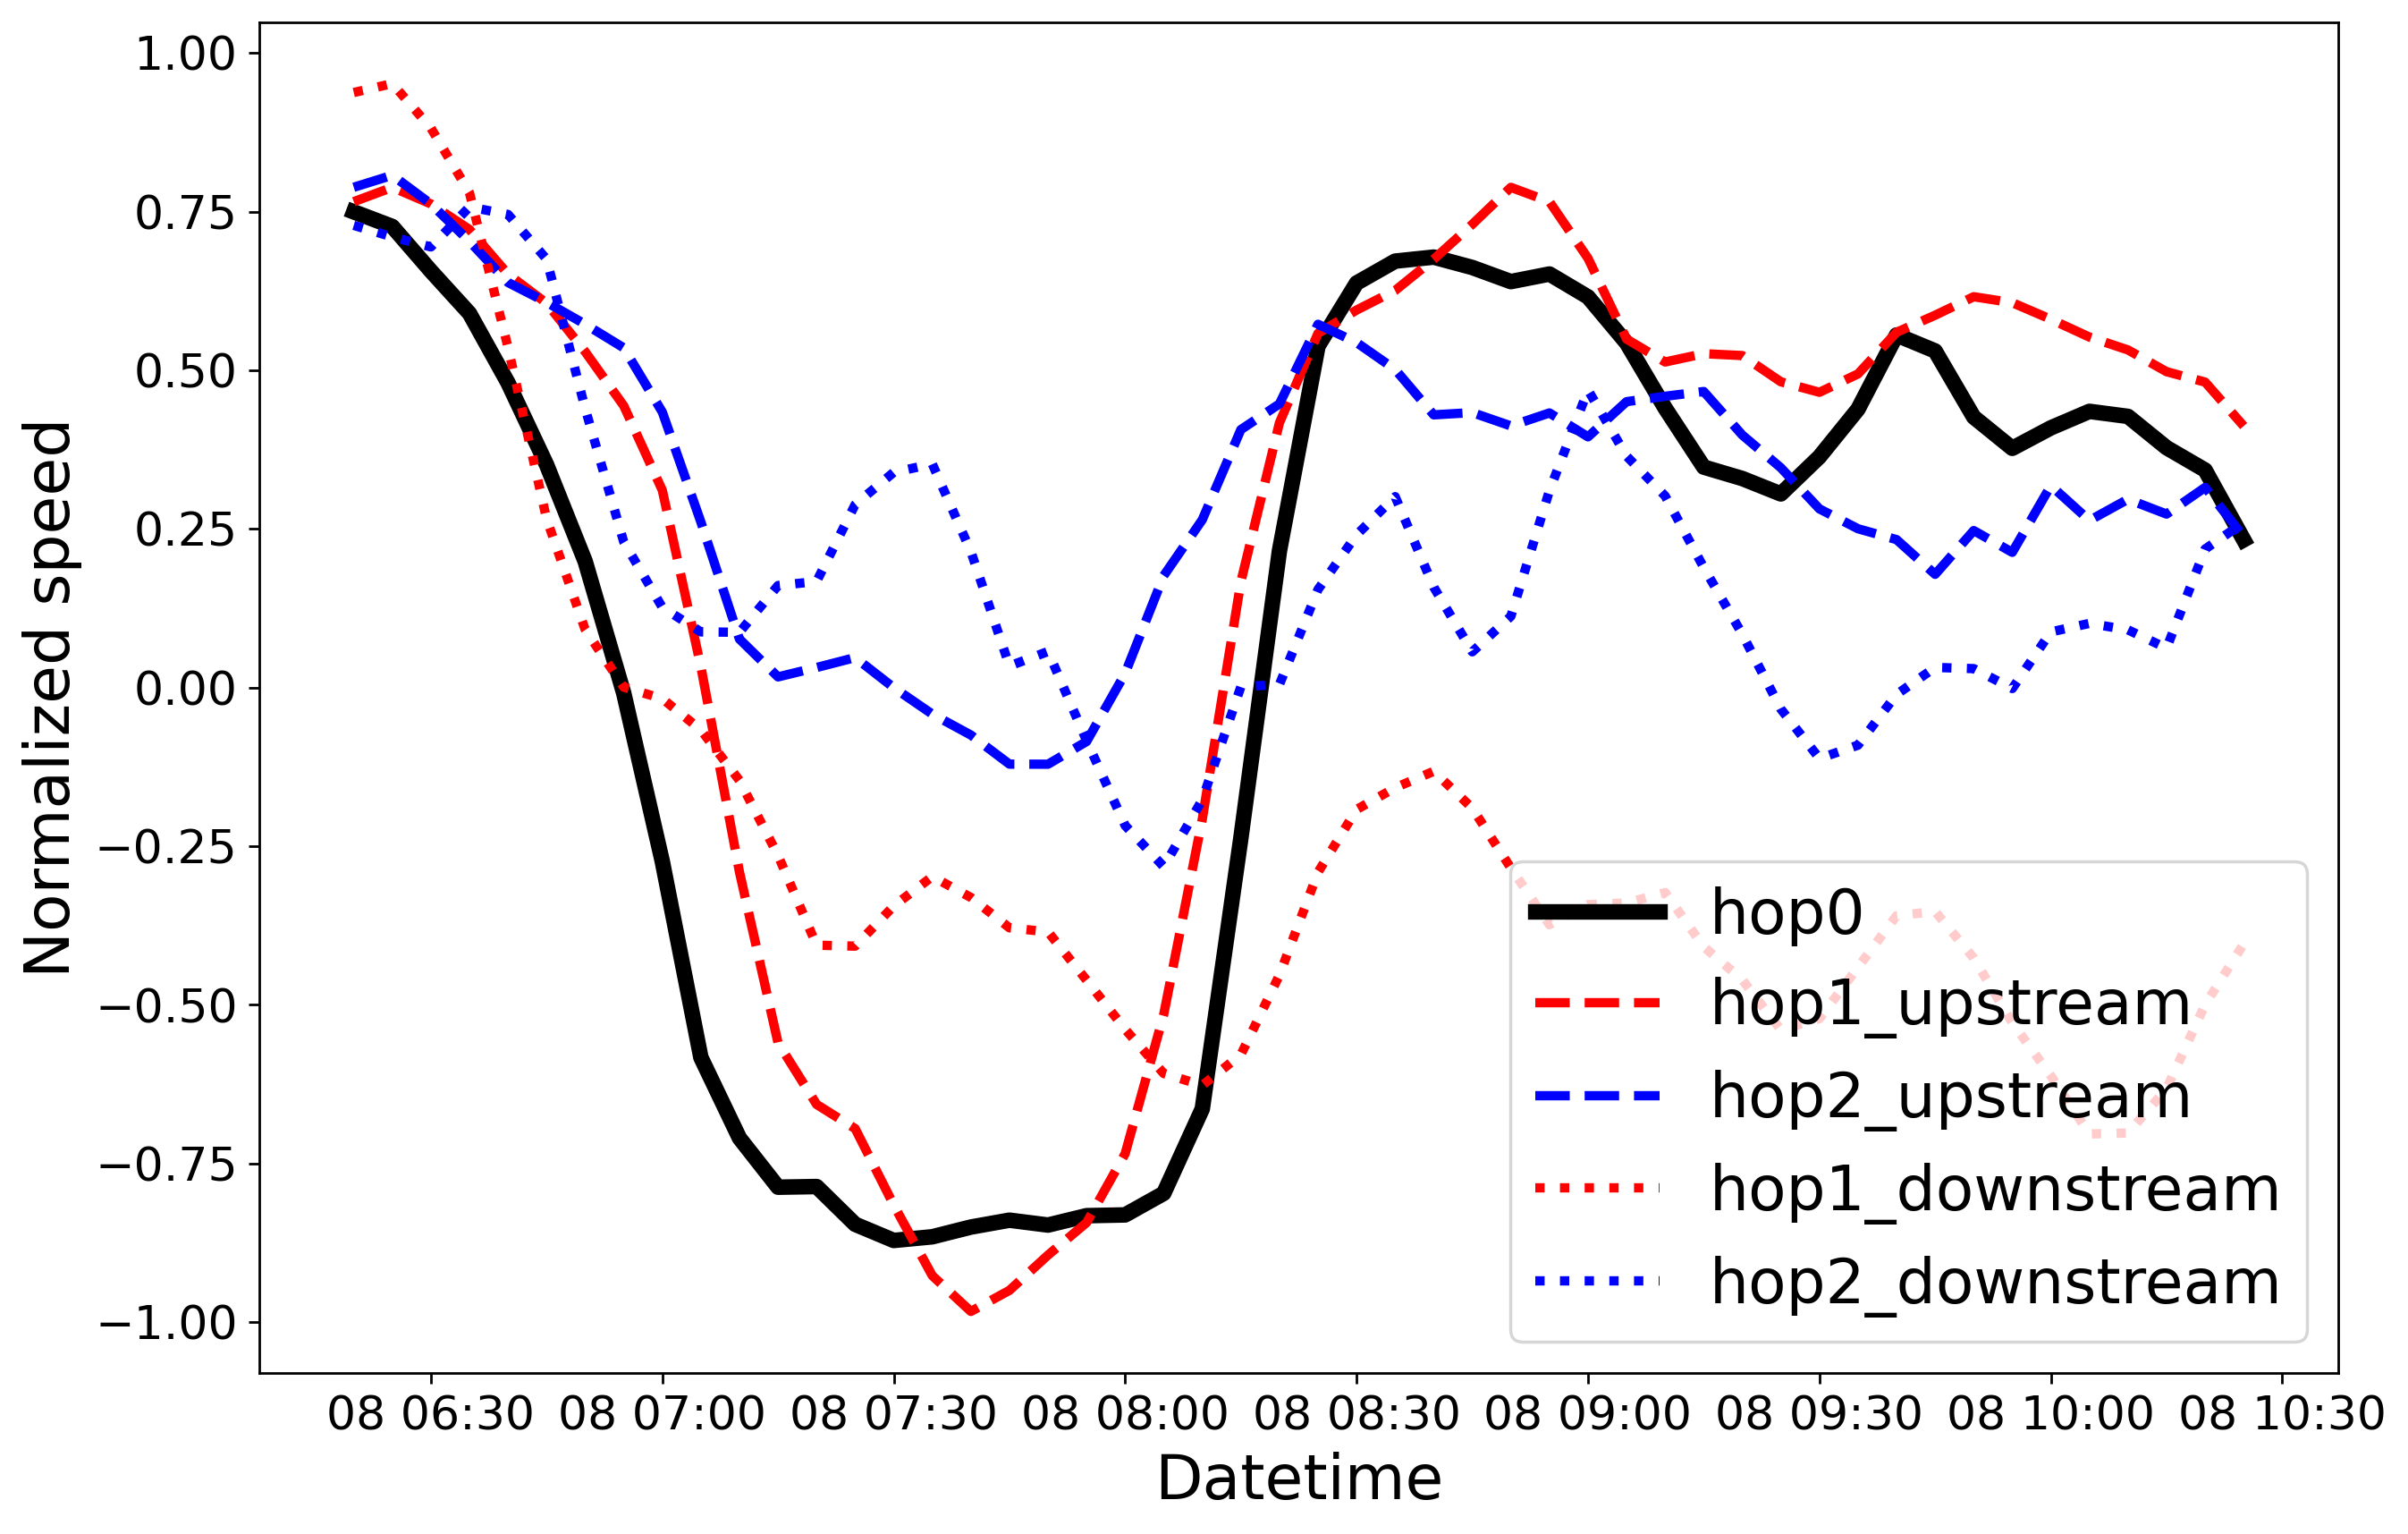

In [25]:
for i in range(4,5):
    t0 = 650 + 288*i
    t1 = 700 + 288*i
    plt.figure(figsize=(12, 8))
    plt.plot(df_agg_inflow.iloc[t0:t1][0], label='hop0', lw=5, color='k', ls='solid')
    plt.plot(df_agg_inflow[t0:t1][1], label='hop1_upstream', lw=3, ls='dashed', color='r')
    plt.plot(df_agg_inflow[t0:t1][2], label='hop2_upstream', lw=3, ls='dashed', color='b')
    plt.plot(df_agg_outflow[t0:t1][2], label='hop1_downstream', lw=3, ls='dotted', color='r')
    plt.plot(df_agg_outflow[t0:t1][1], label='hop2_downstream', lw=3, ls='dotted', color='b')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(prop={'size':20})
    # plt.title('Recurrent Congestion Example', size=18)
    plt.xlabel('Datetime', size=20)
    plt.ylabel('Normalized speed', size=20)
    plt.legend(fontsize=20)
    
    # plt.rcParams['figure.dpi'] = 250
    plt.savefig('../images/recurrent_example2.pdf', dpi=250, bbox_inches = 'tight')
    plt.show()
    

## Incident Data

2021-01-02 14:10:00
2021-01-04 06:46:00
2021-01-09 12:27:00
2021-01-10 17:52:00
2021-01-12 06:54:00
2021-01-25 06:46:00
2021-01-25 21:23:00
2021-02-13 13:10:00
2021-02-17 12:53:00
2021-02-21 11:46:00
2021-02-26 07:10:00


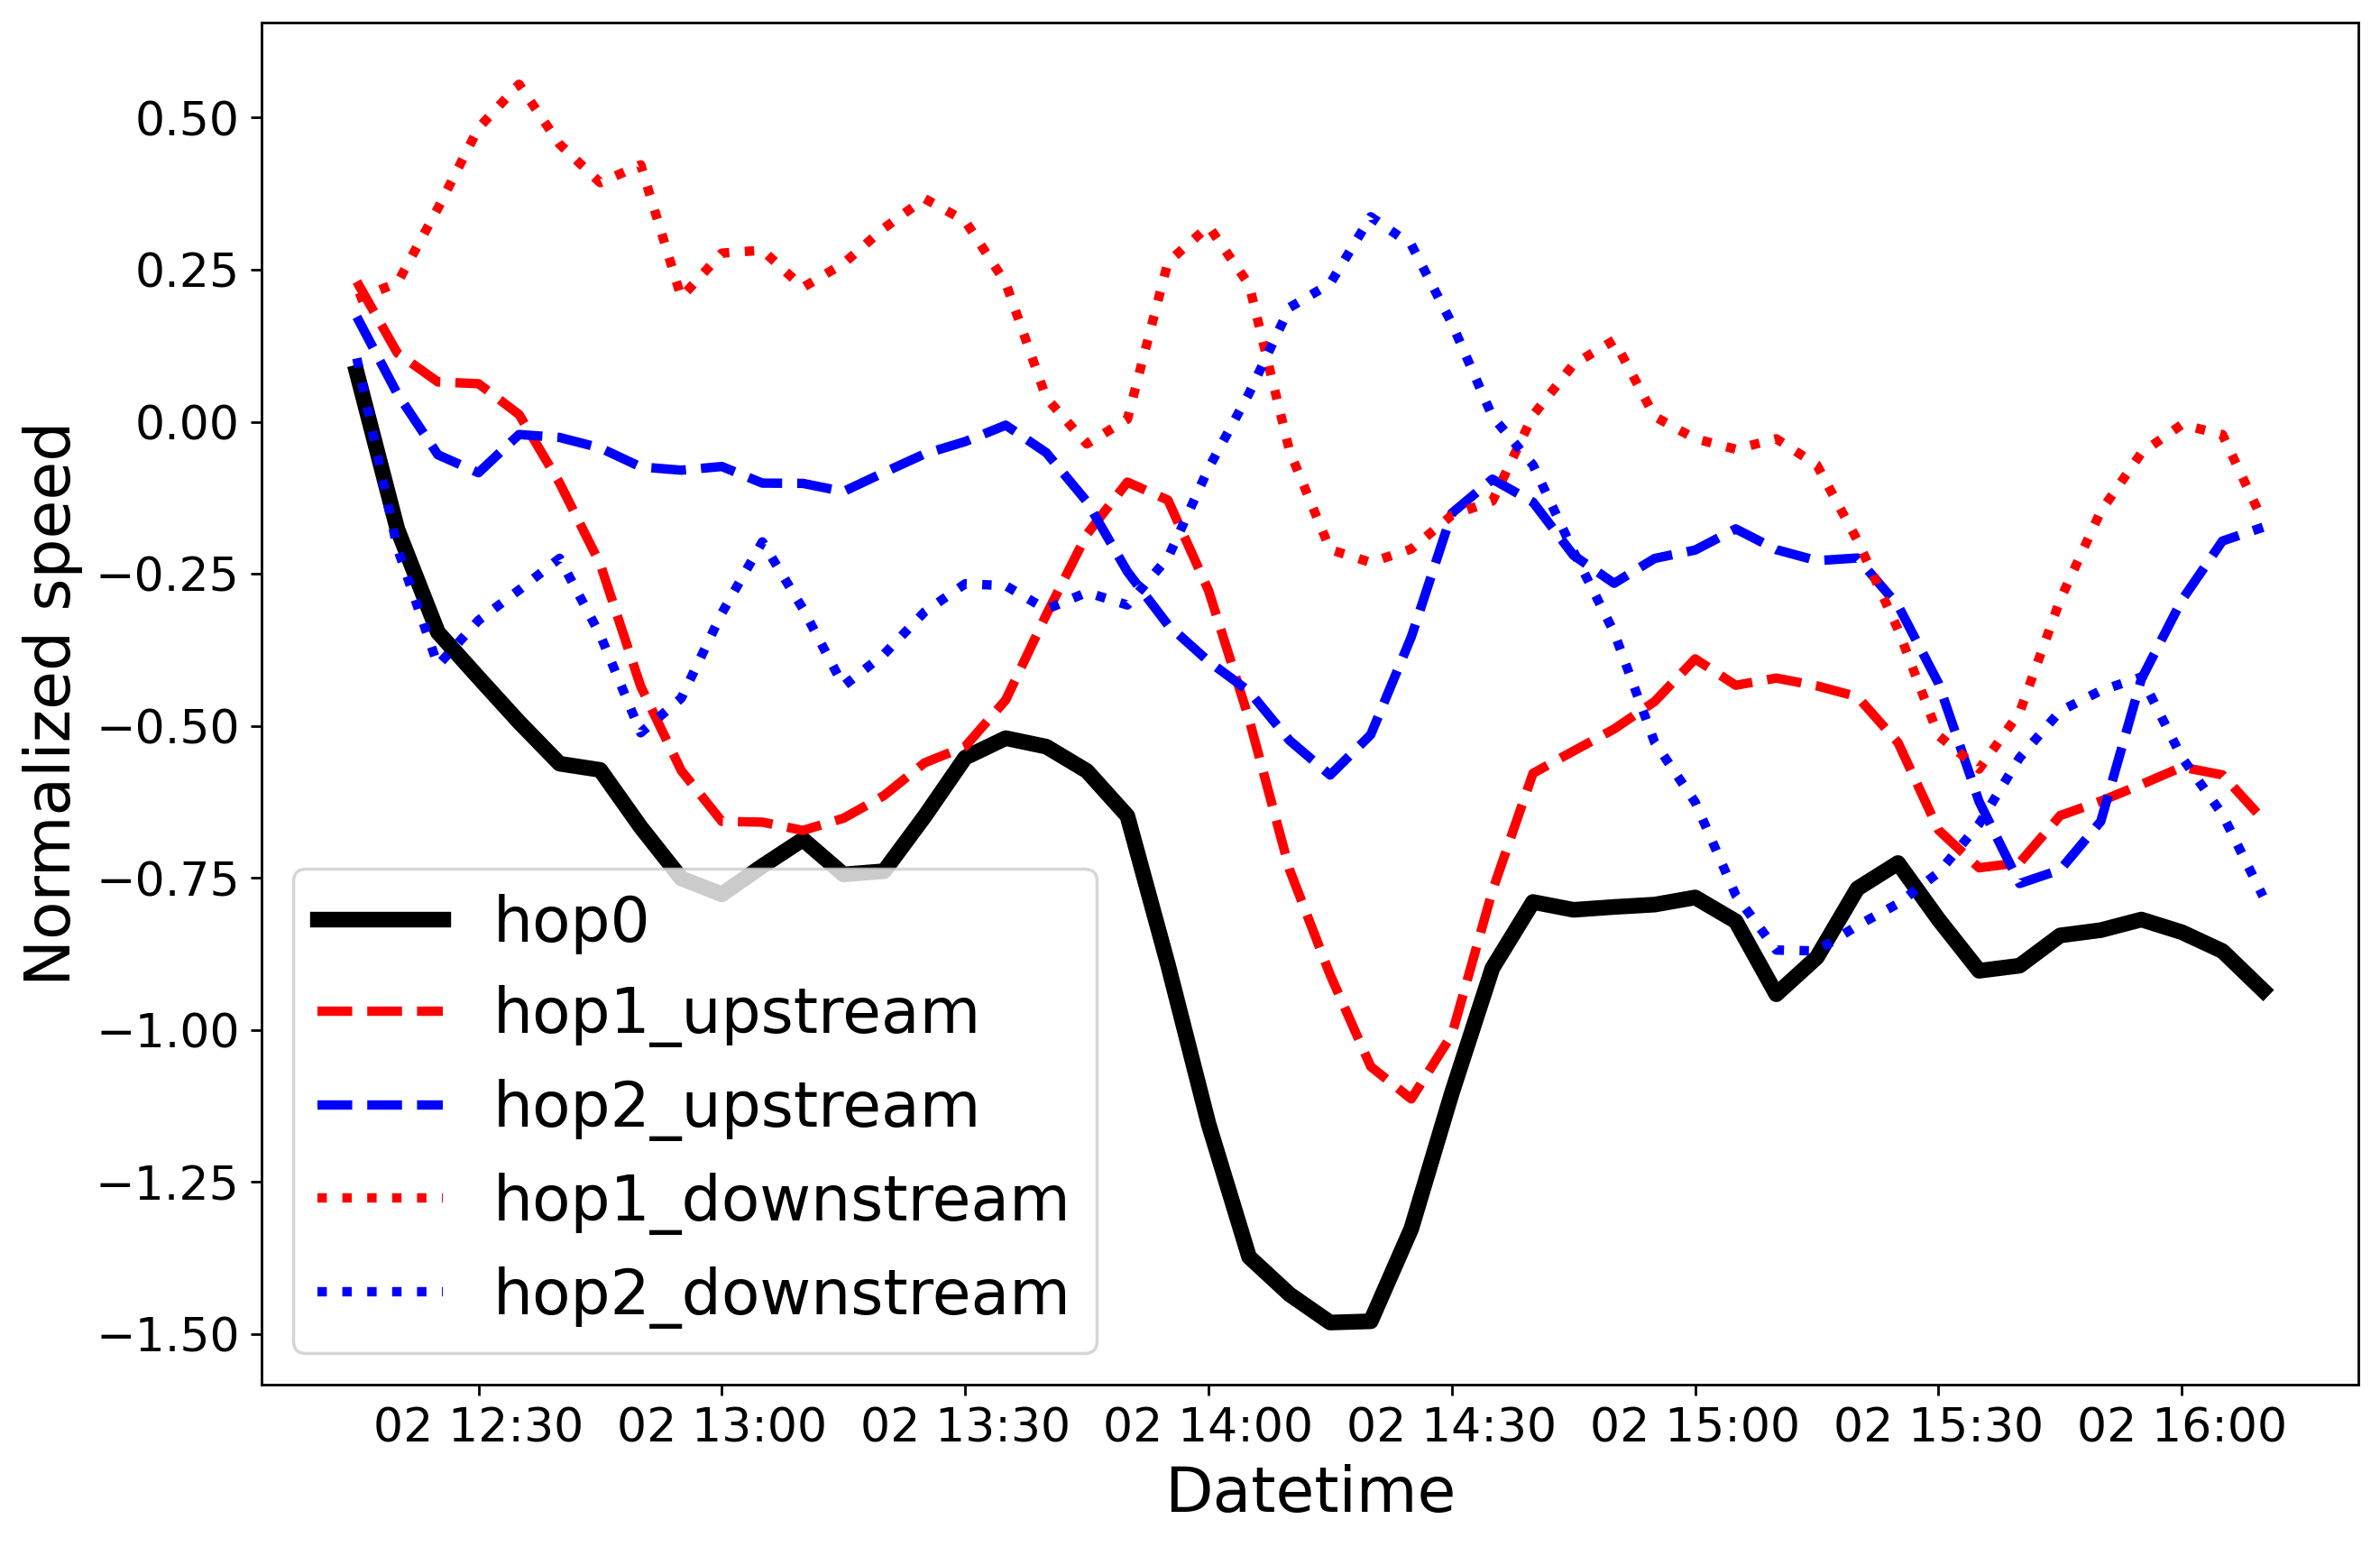

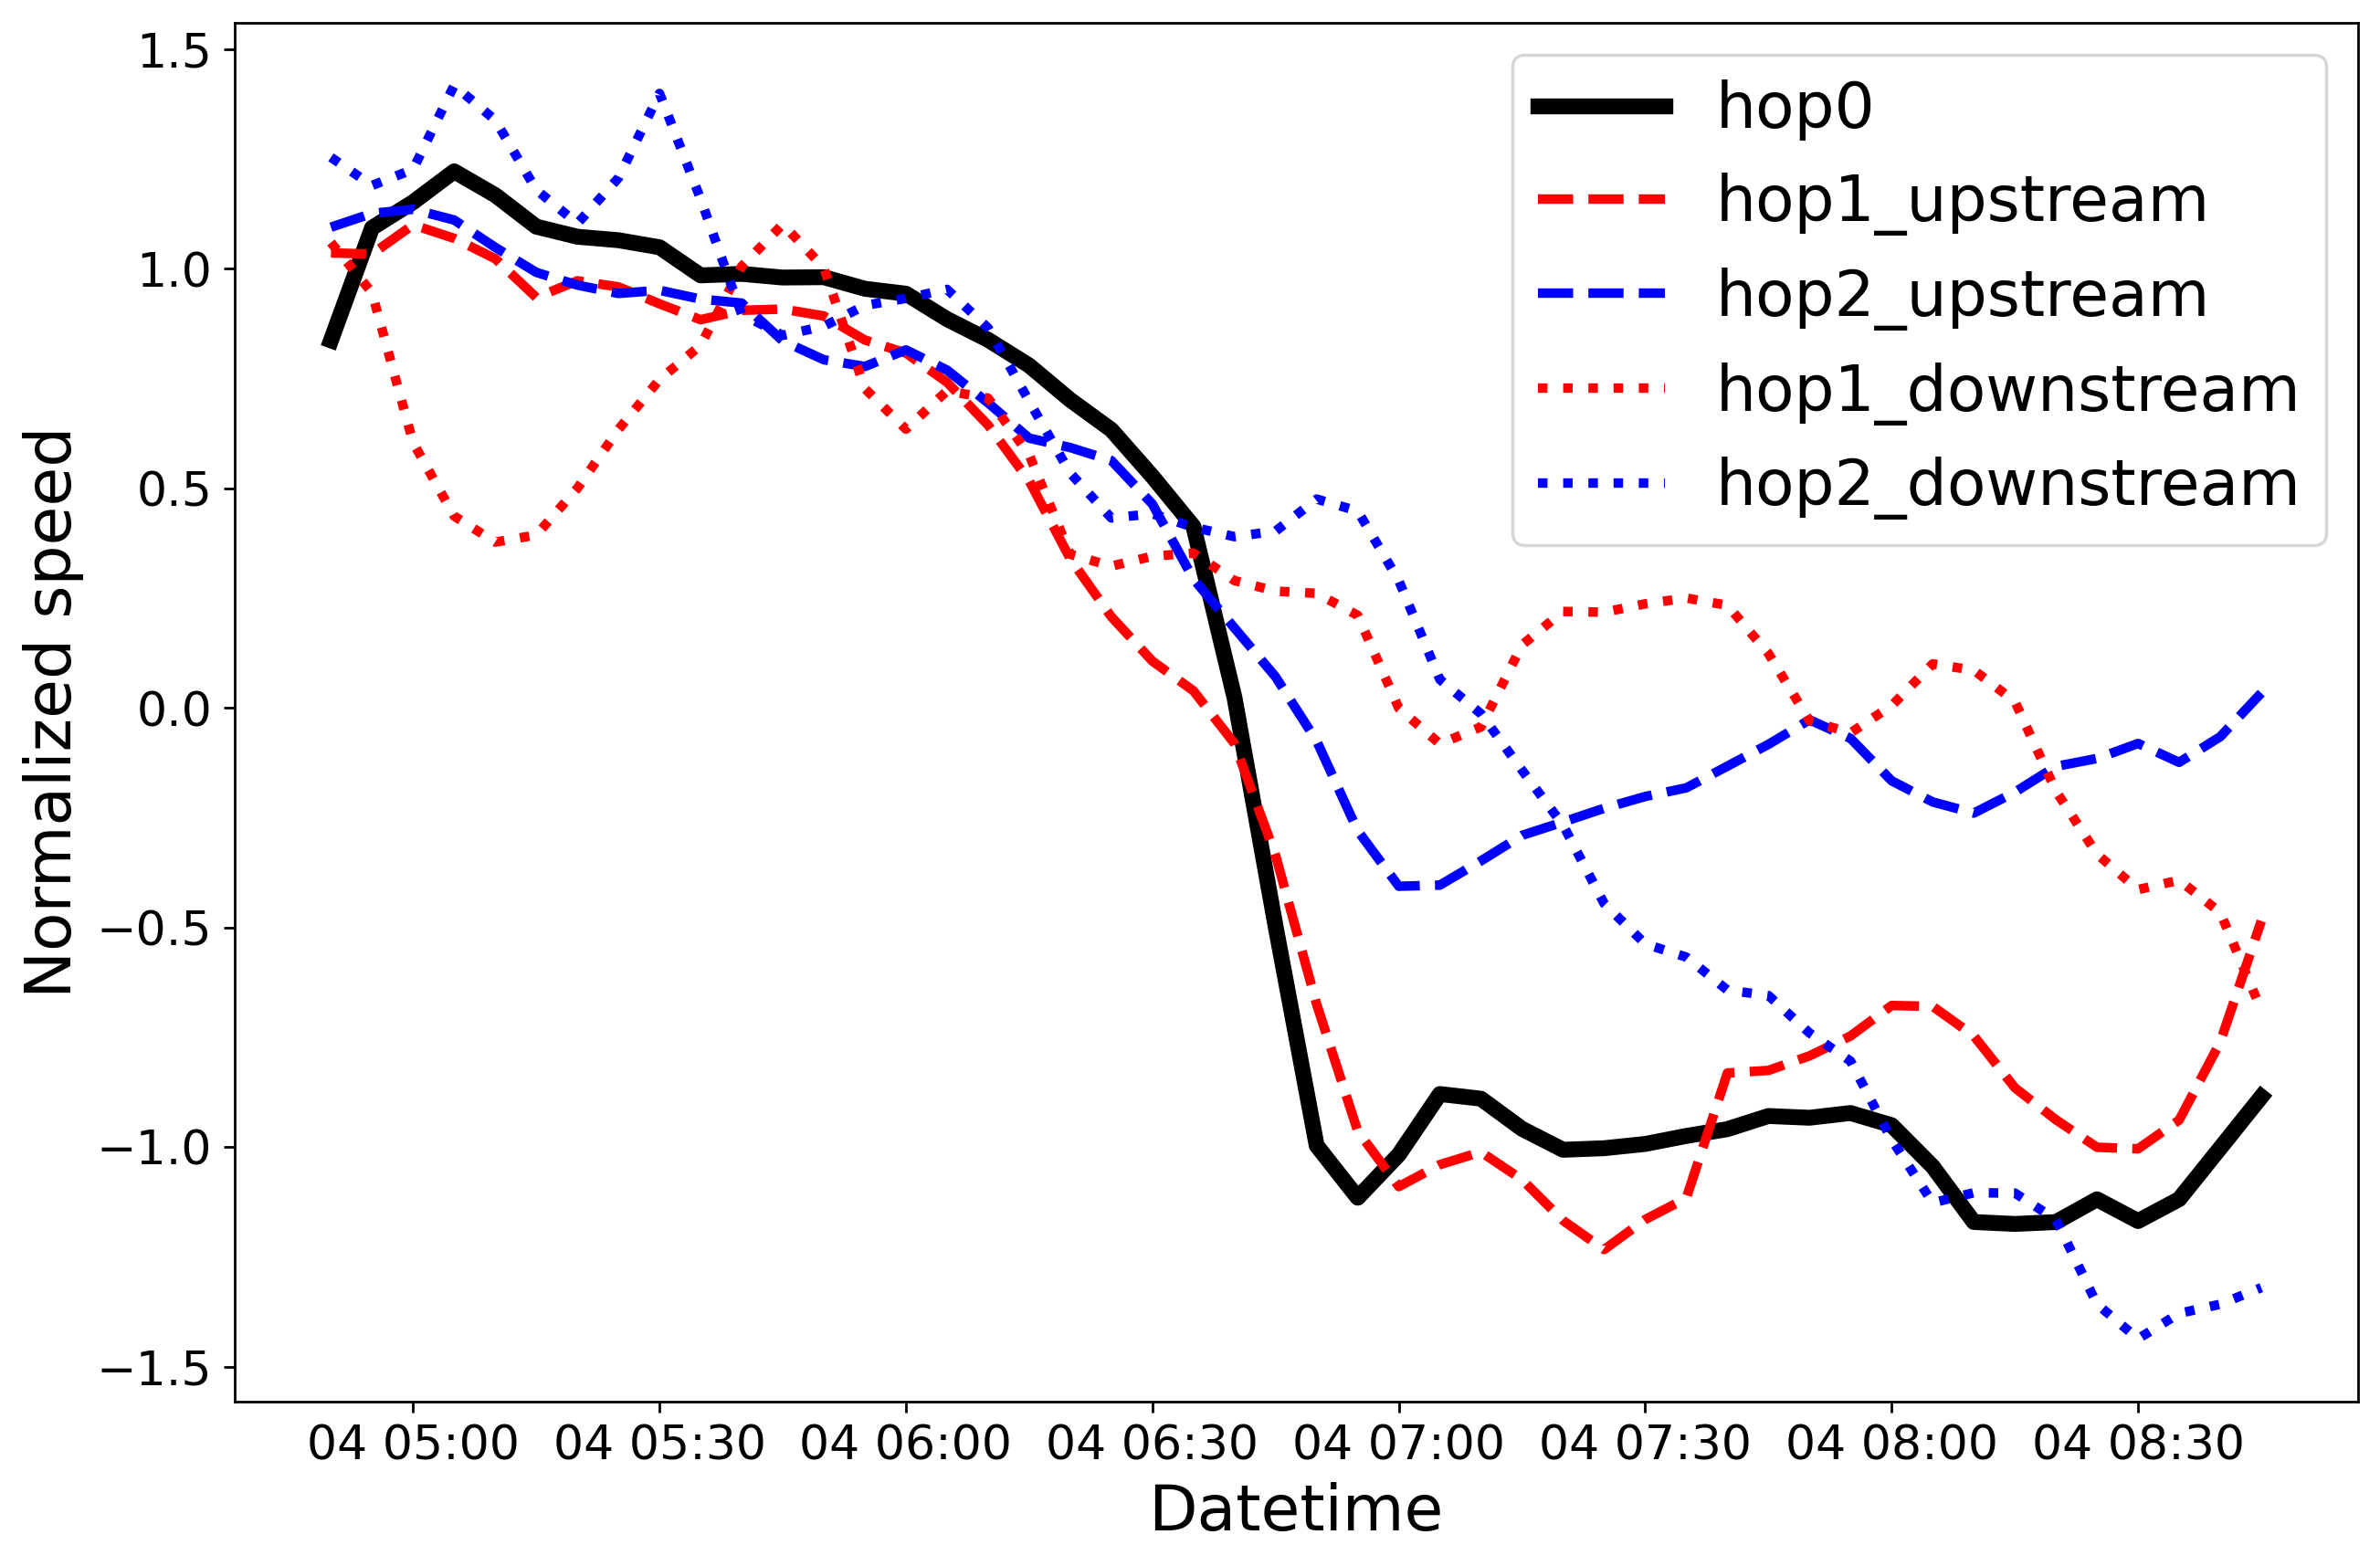

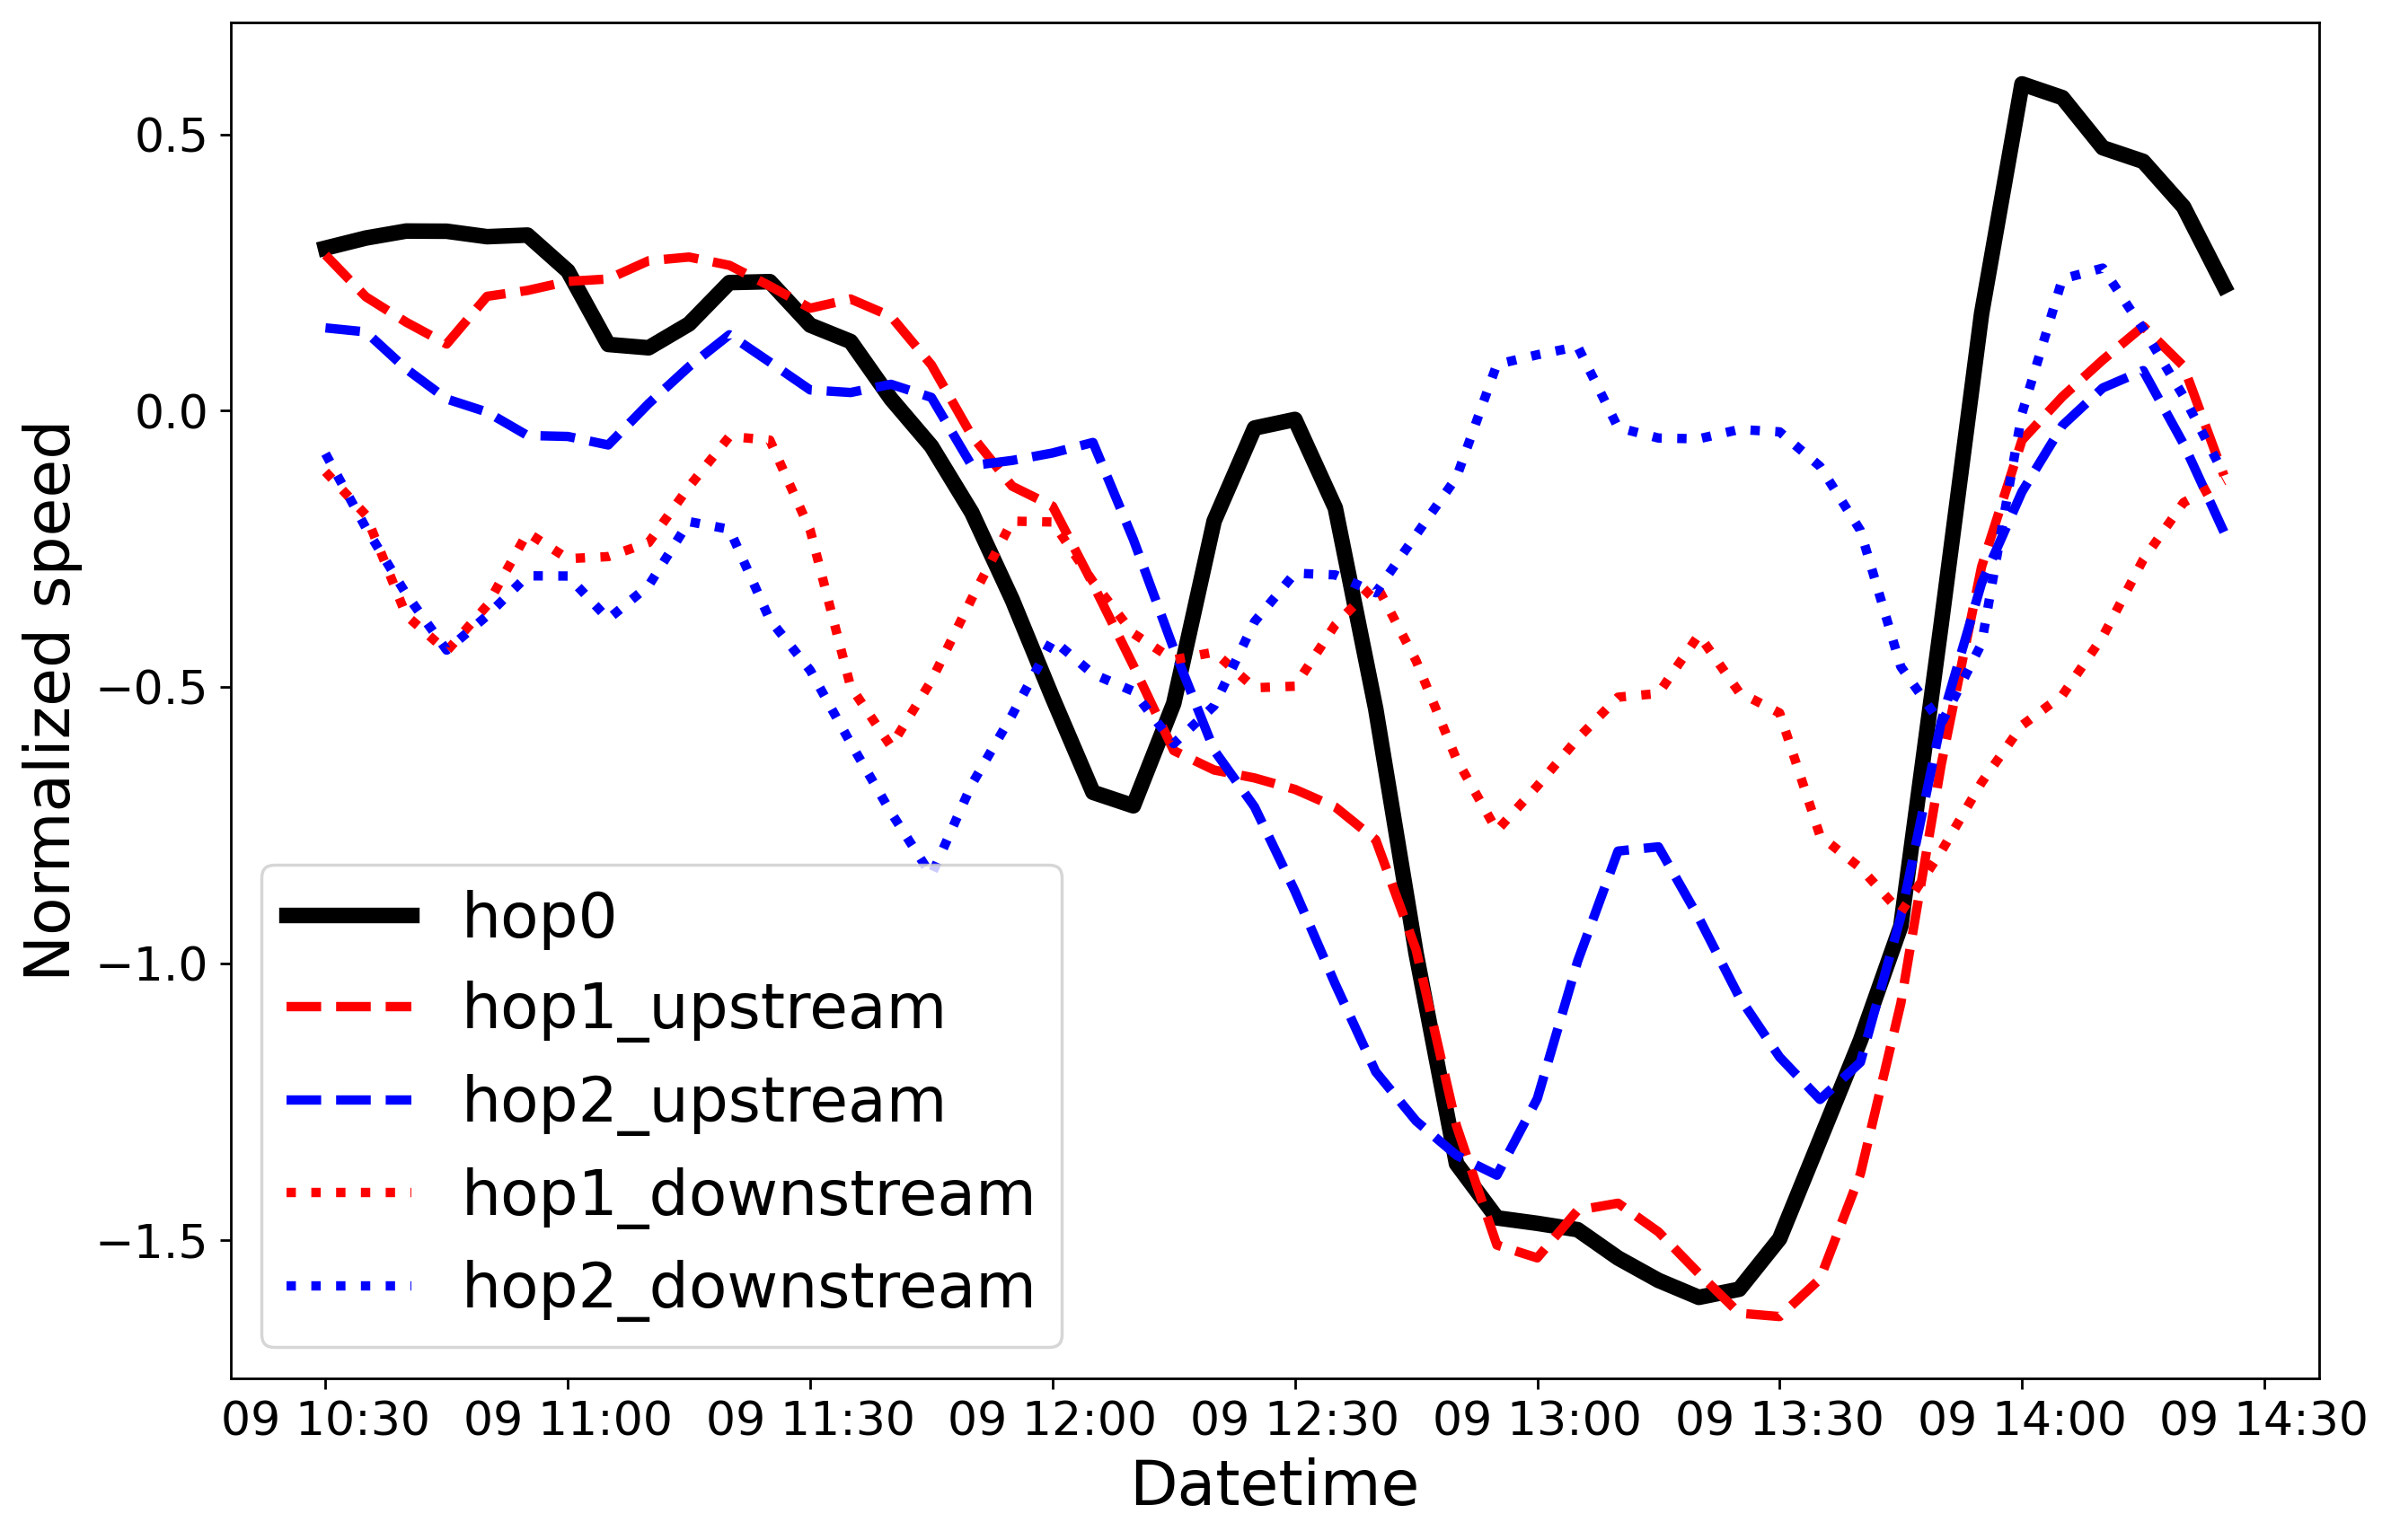

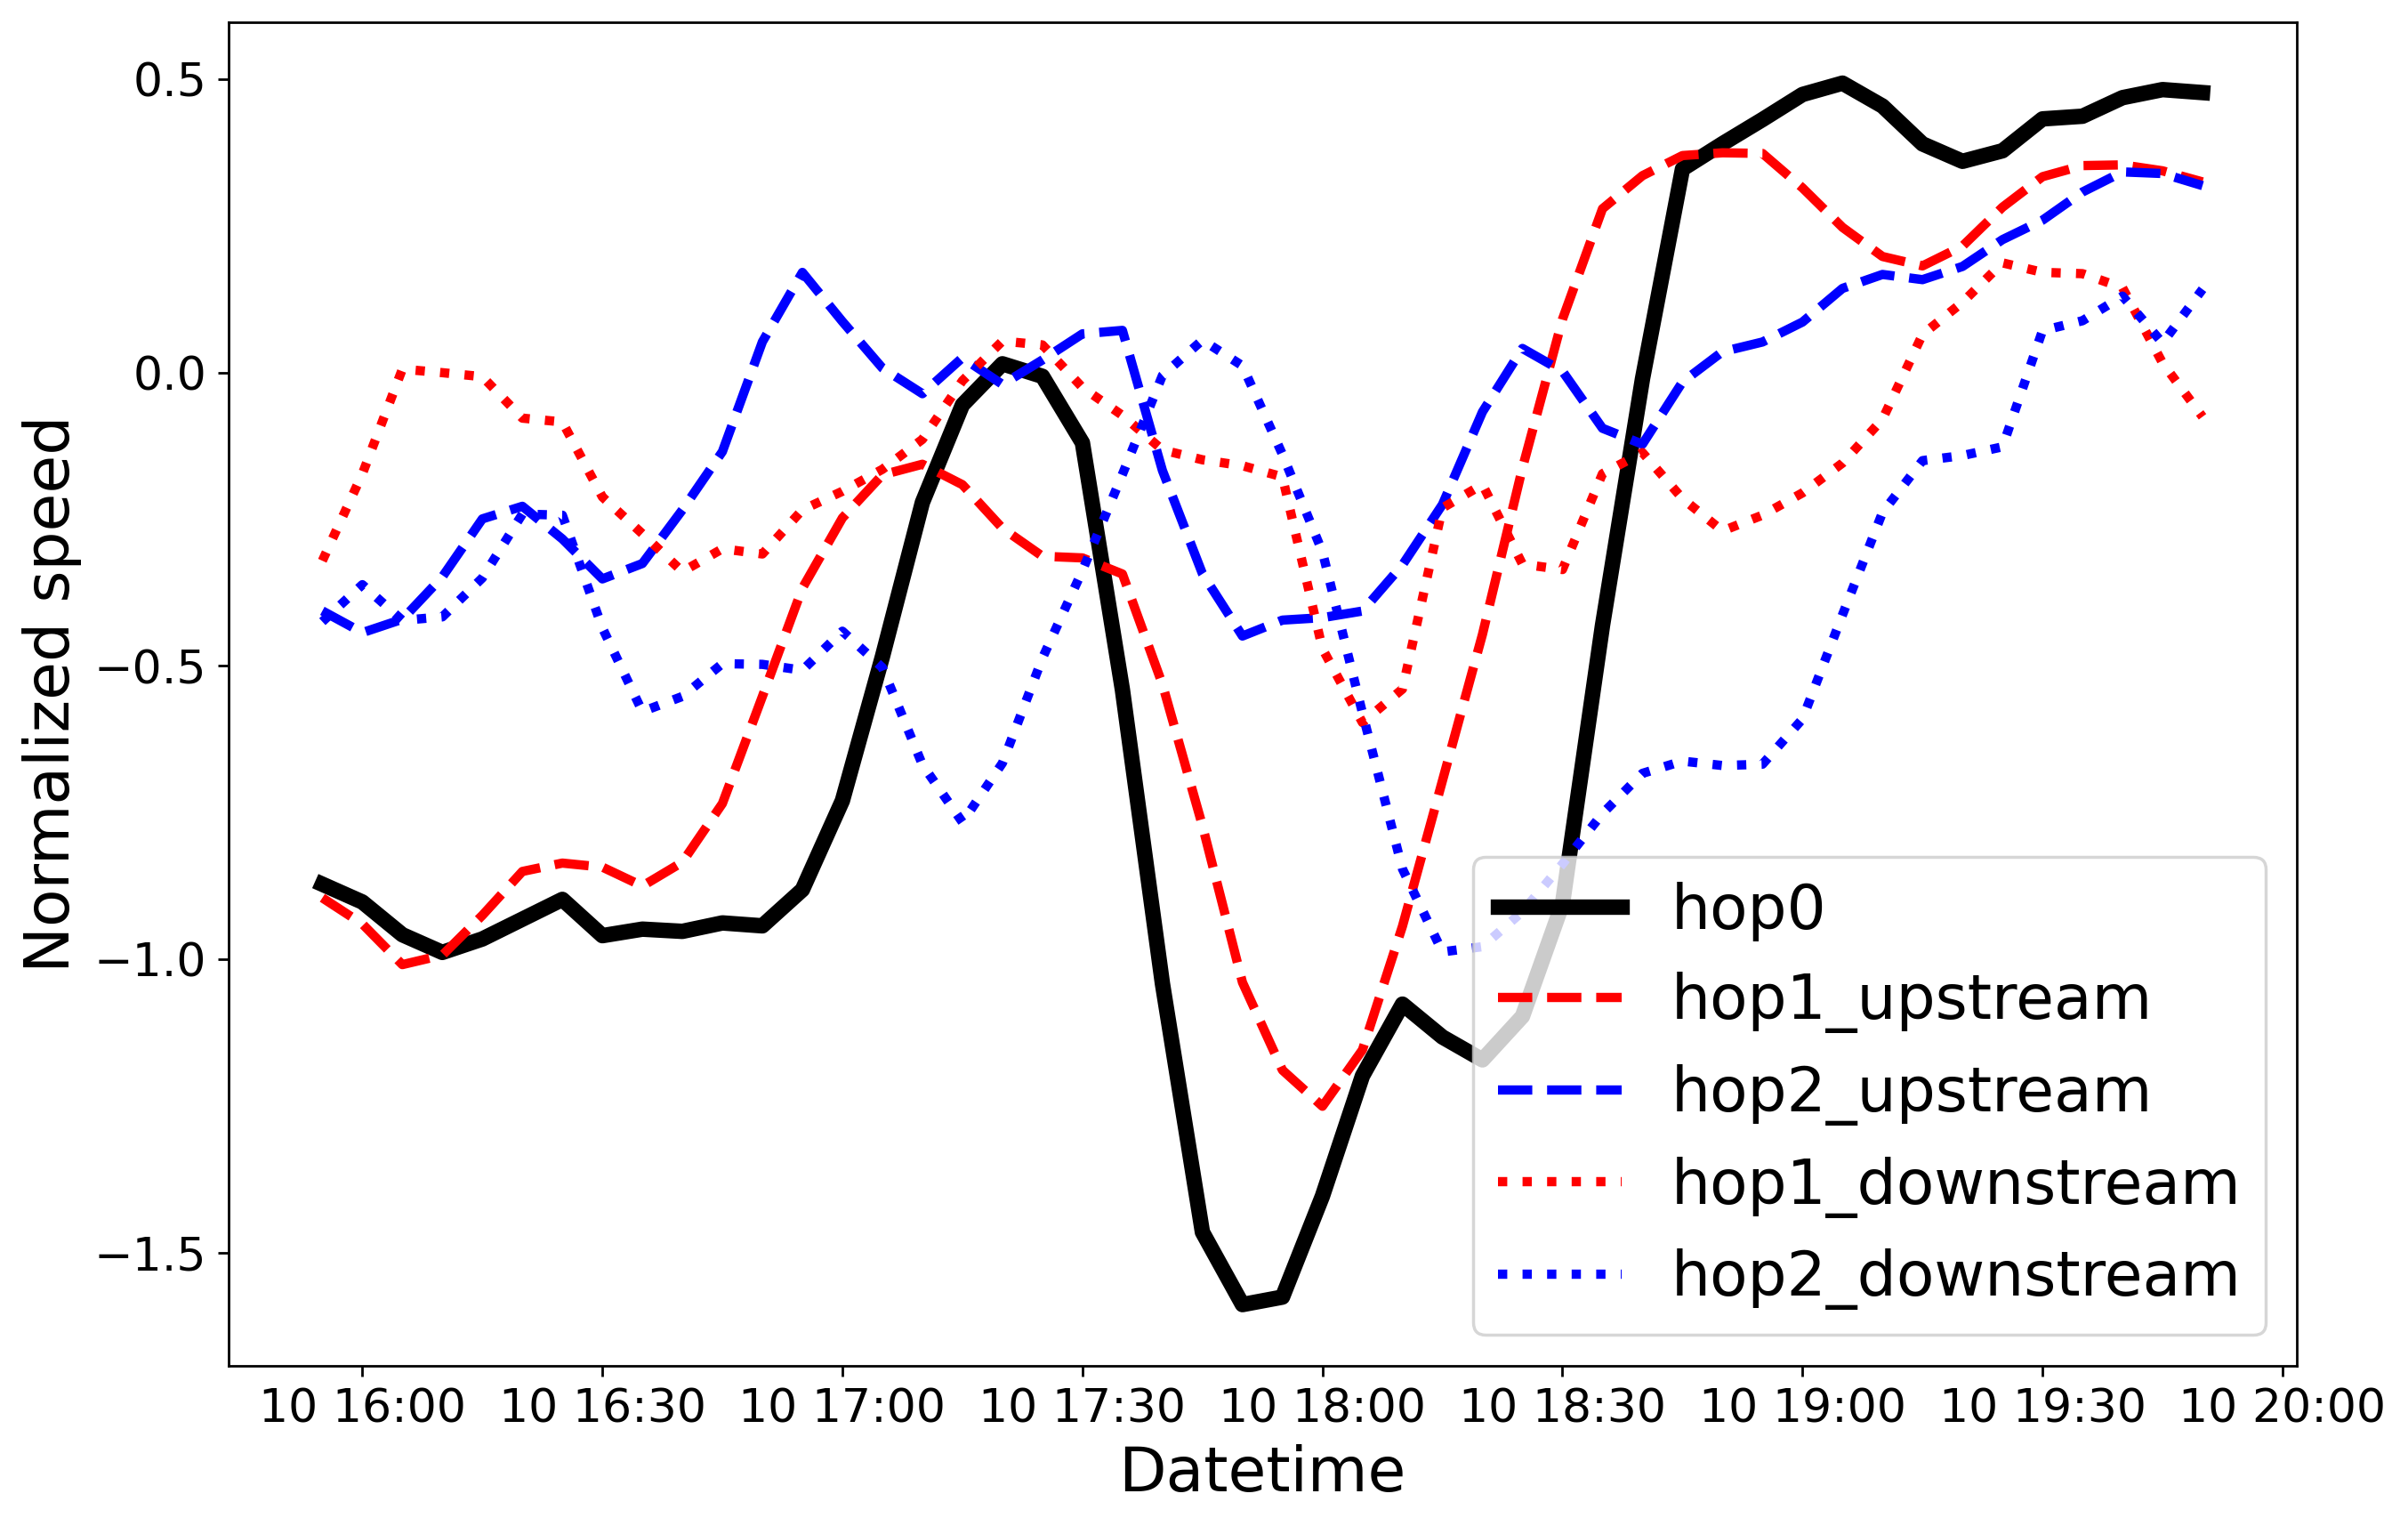

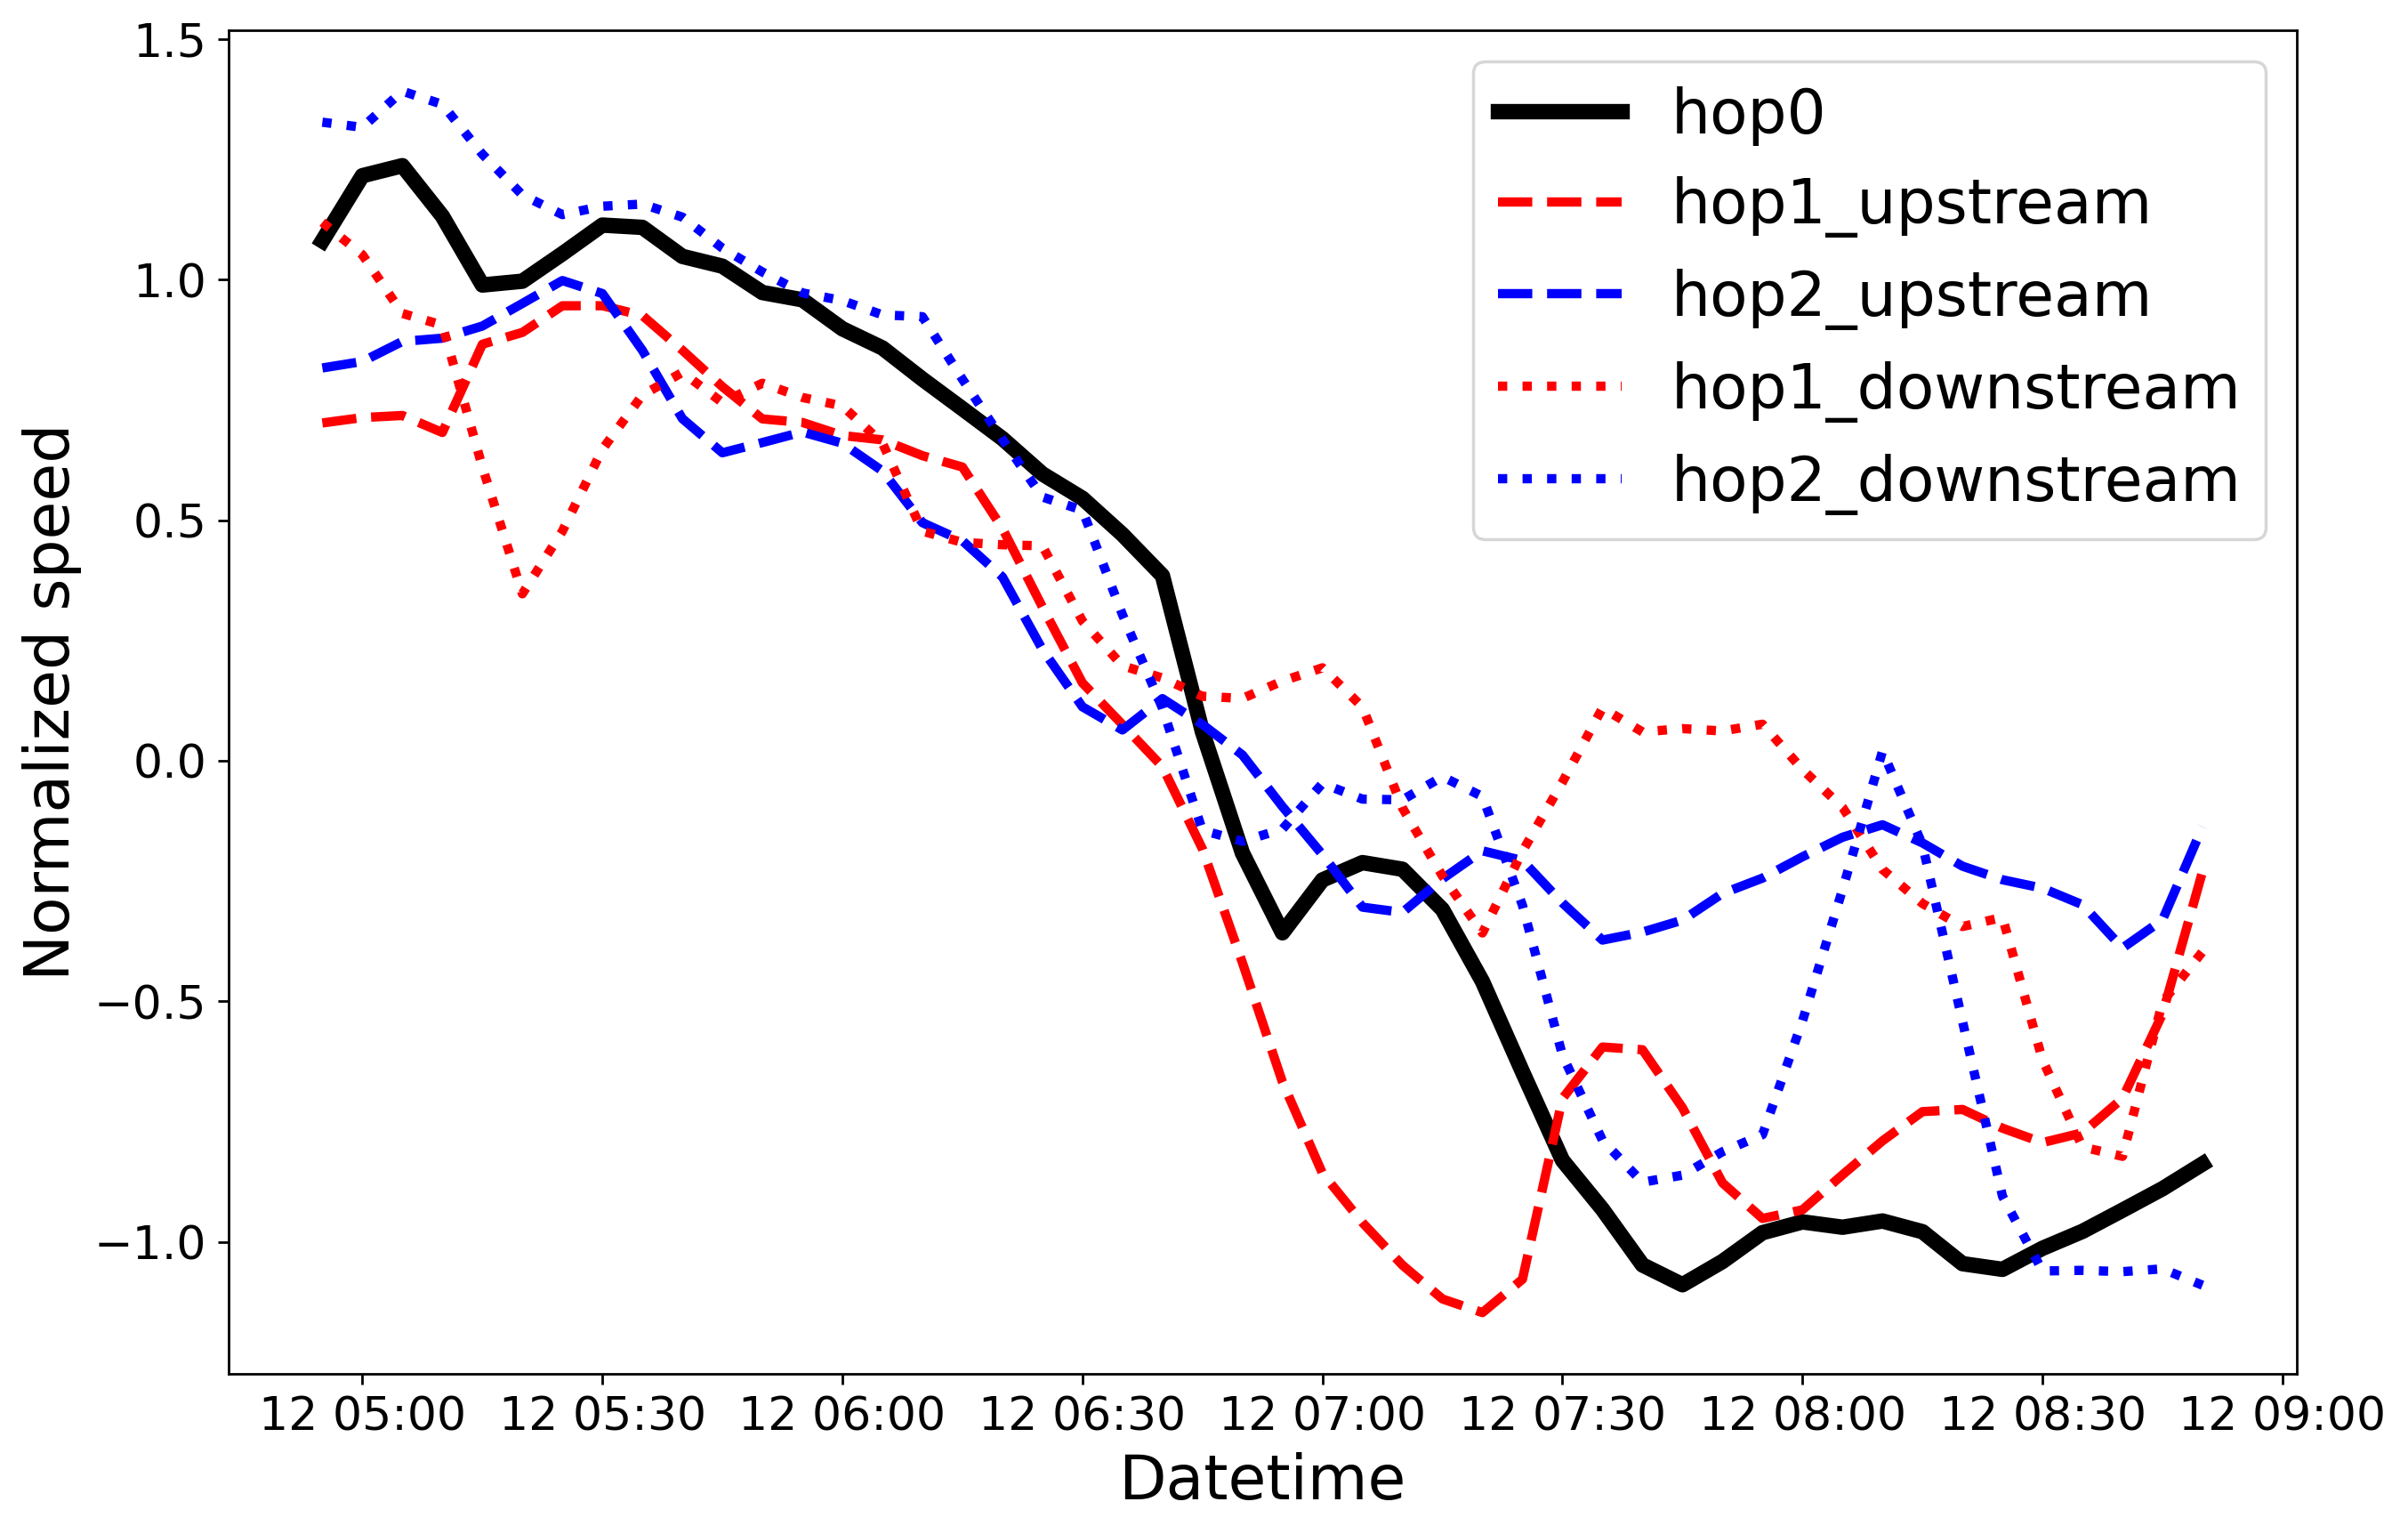

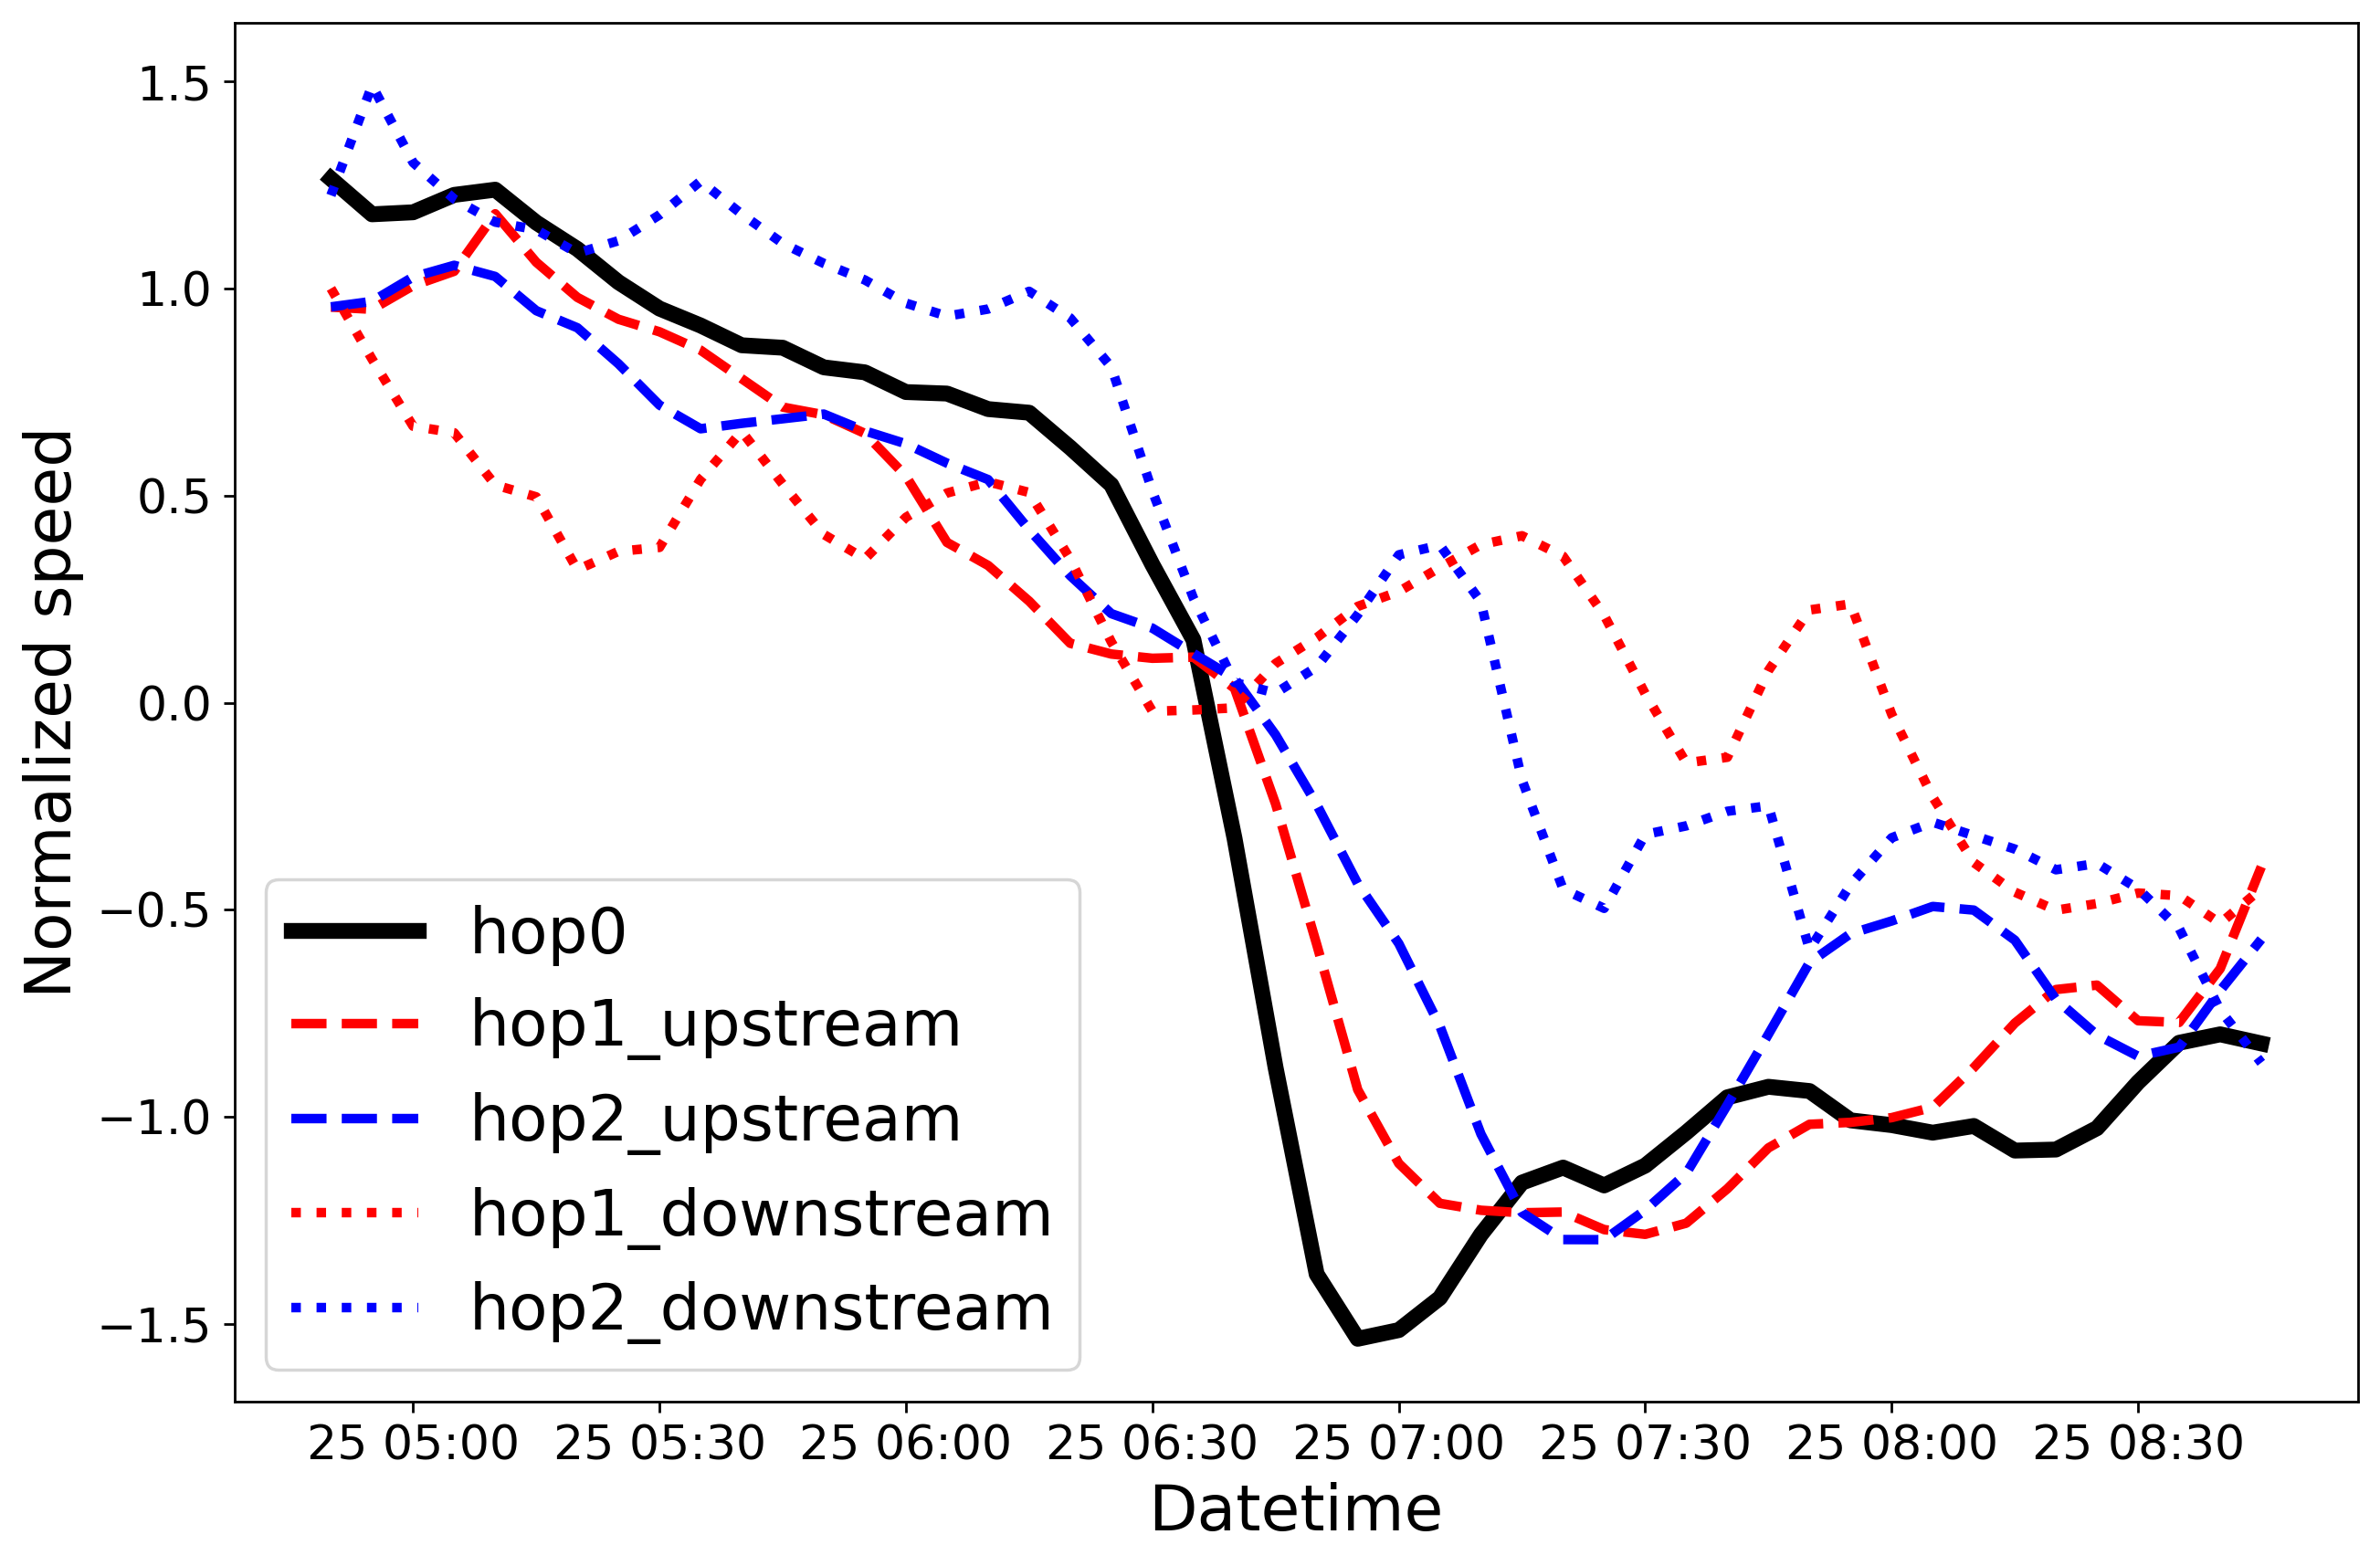

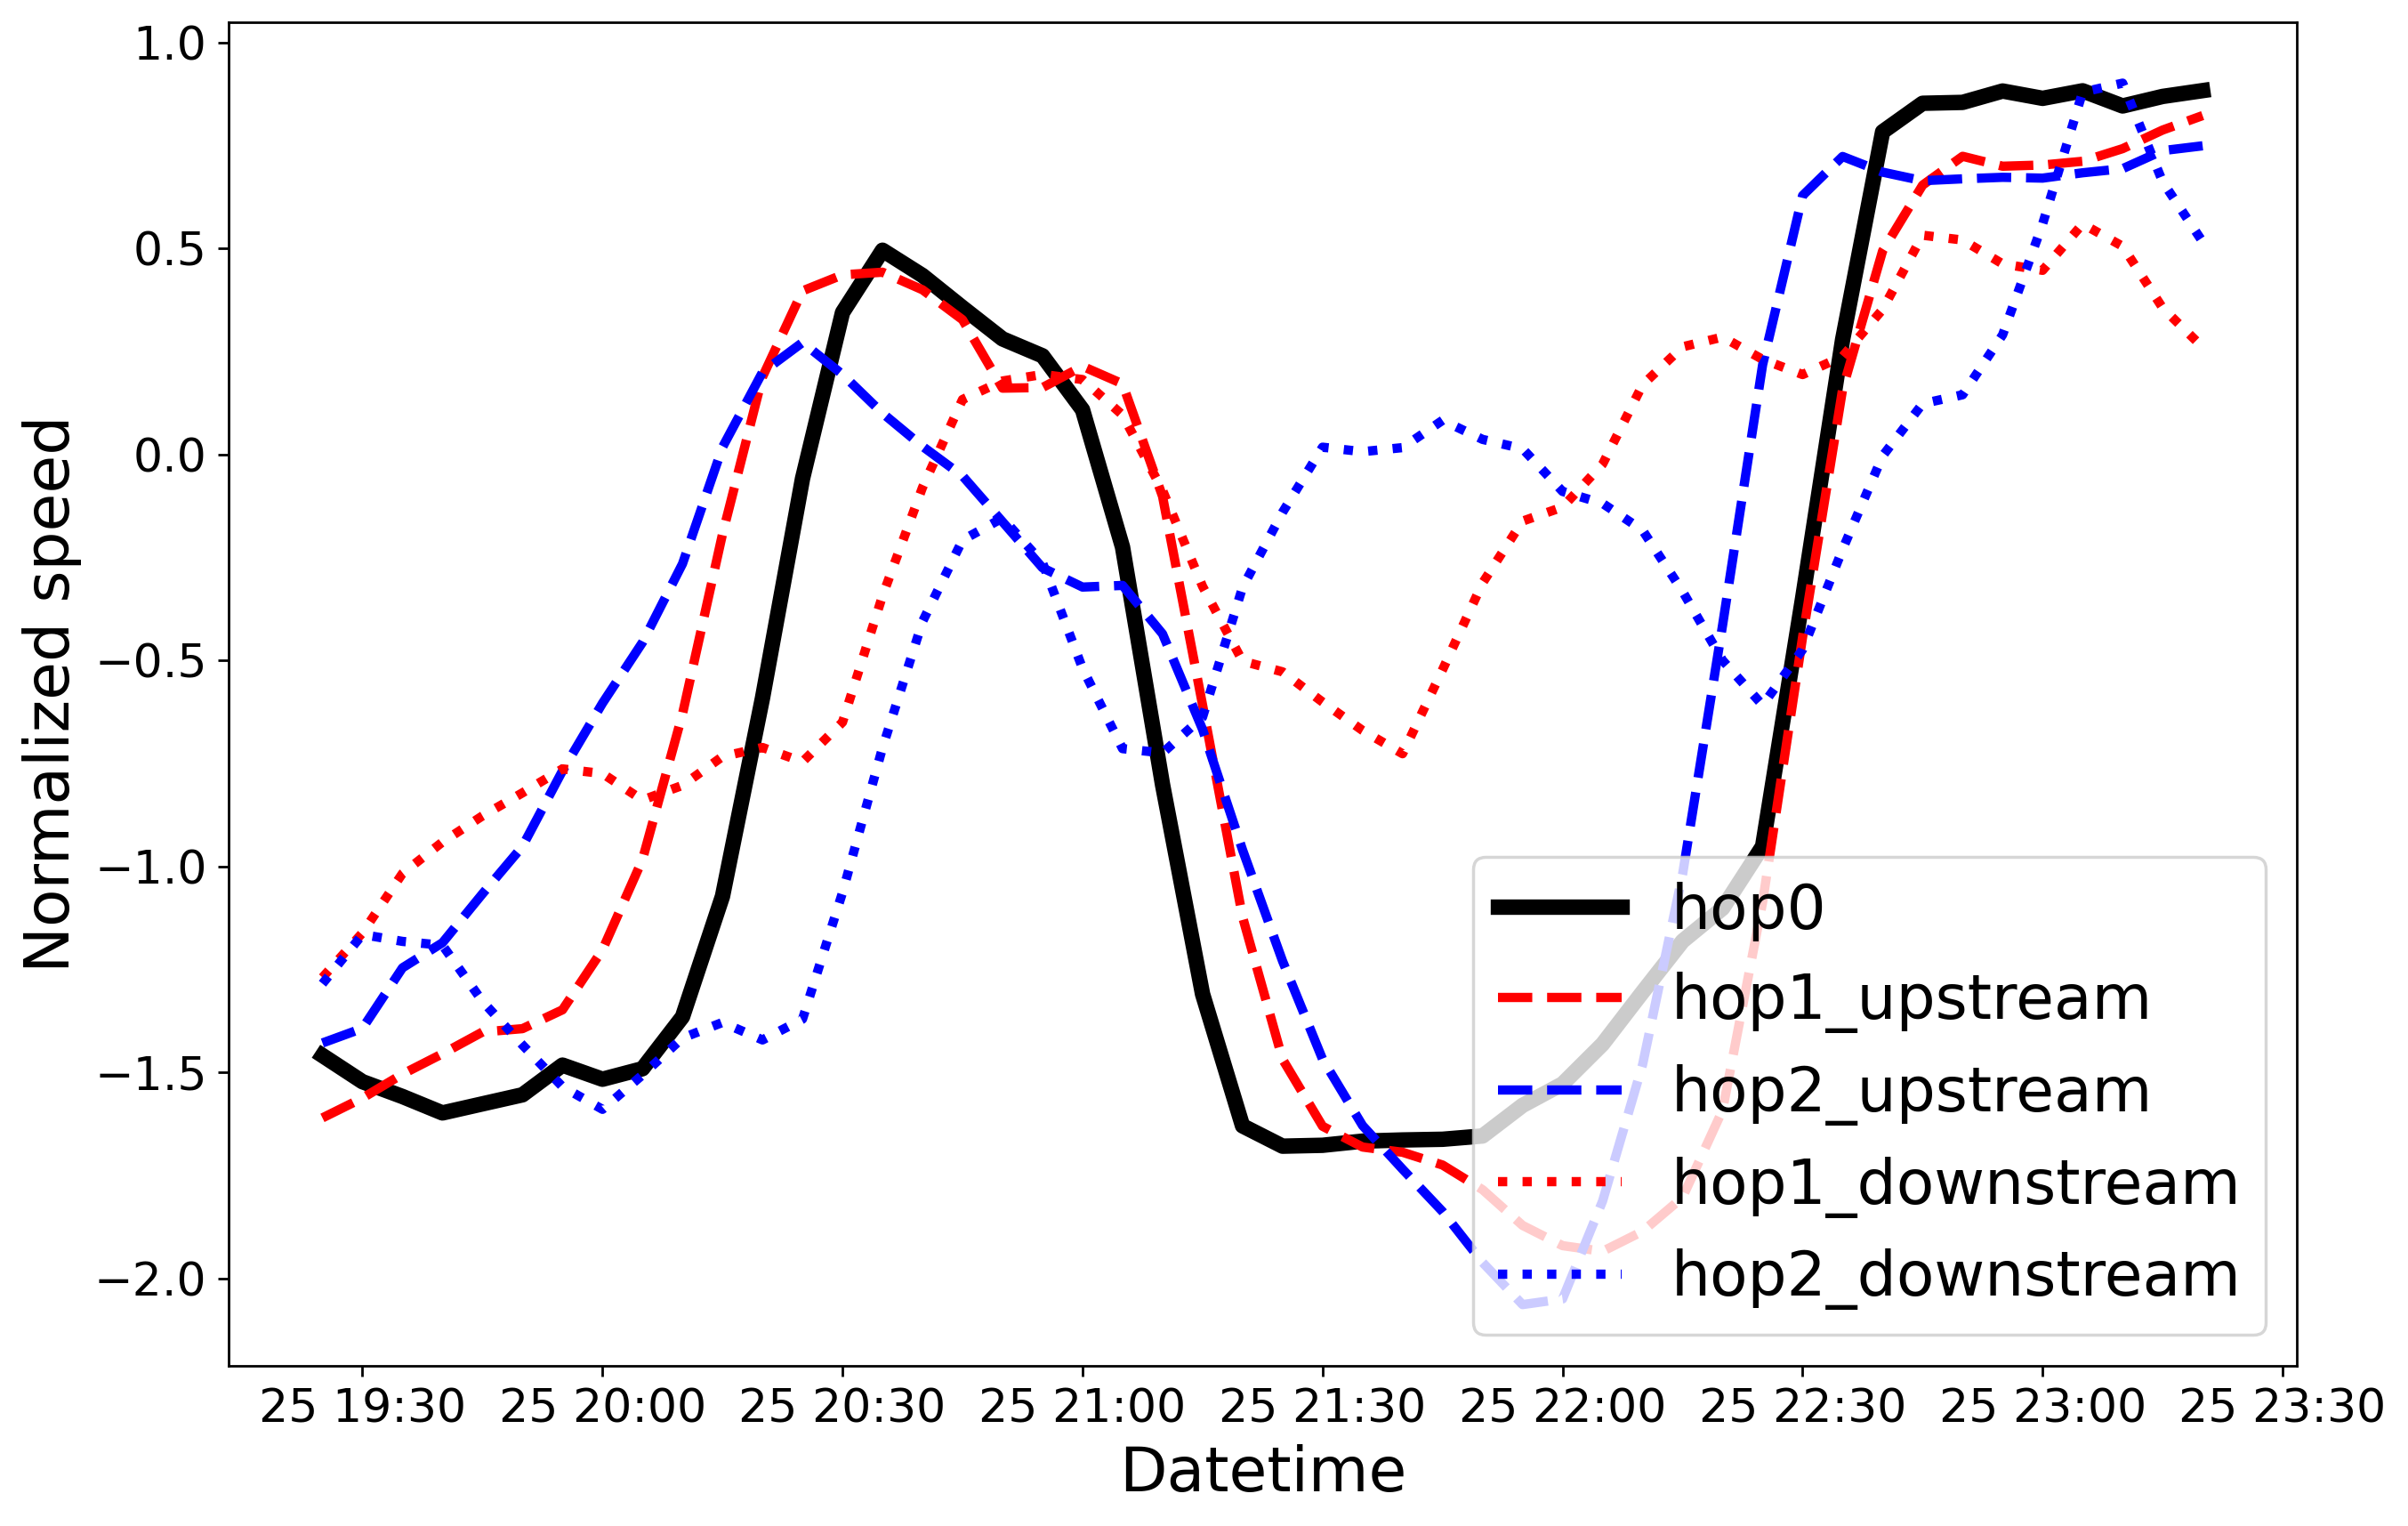

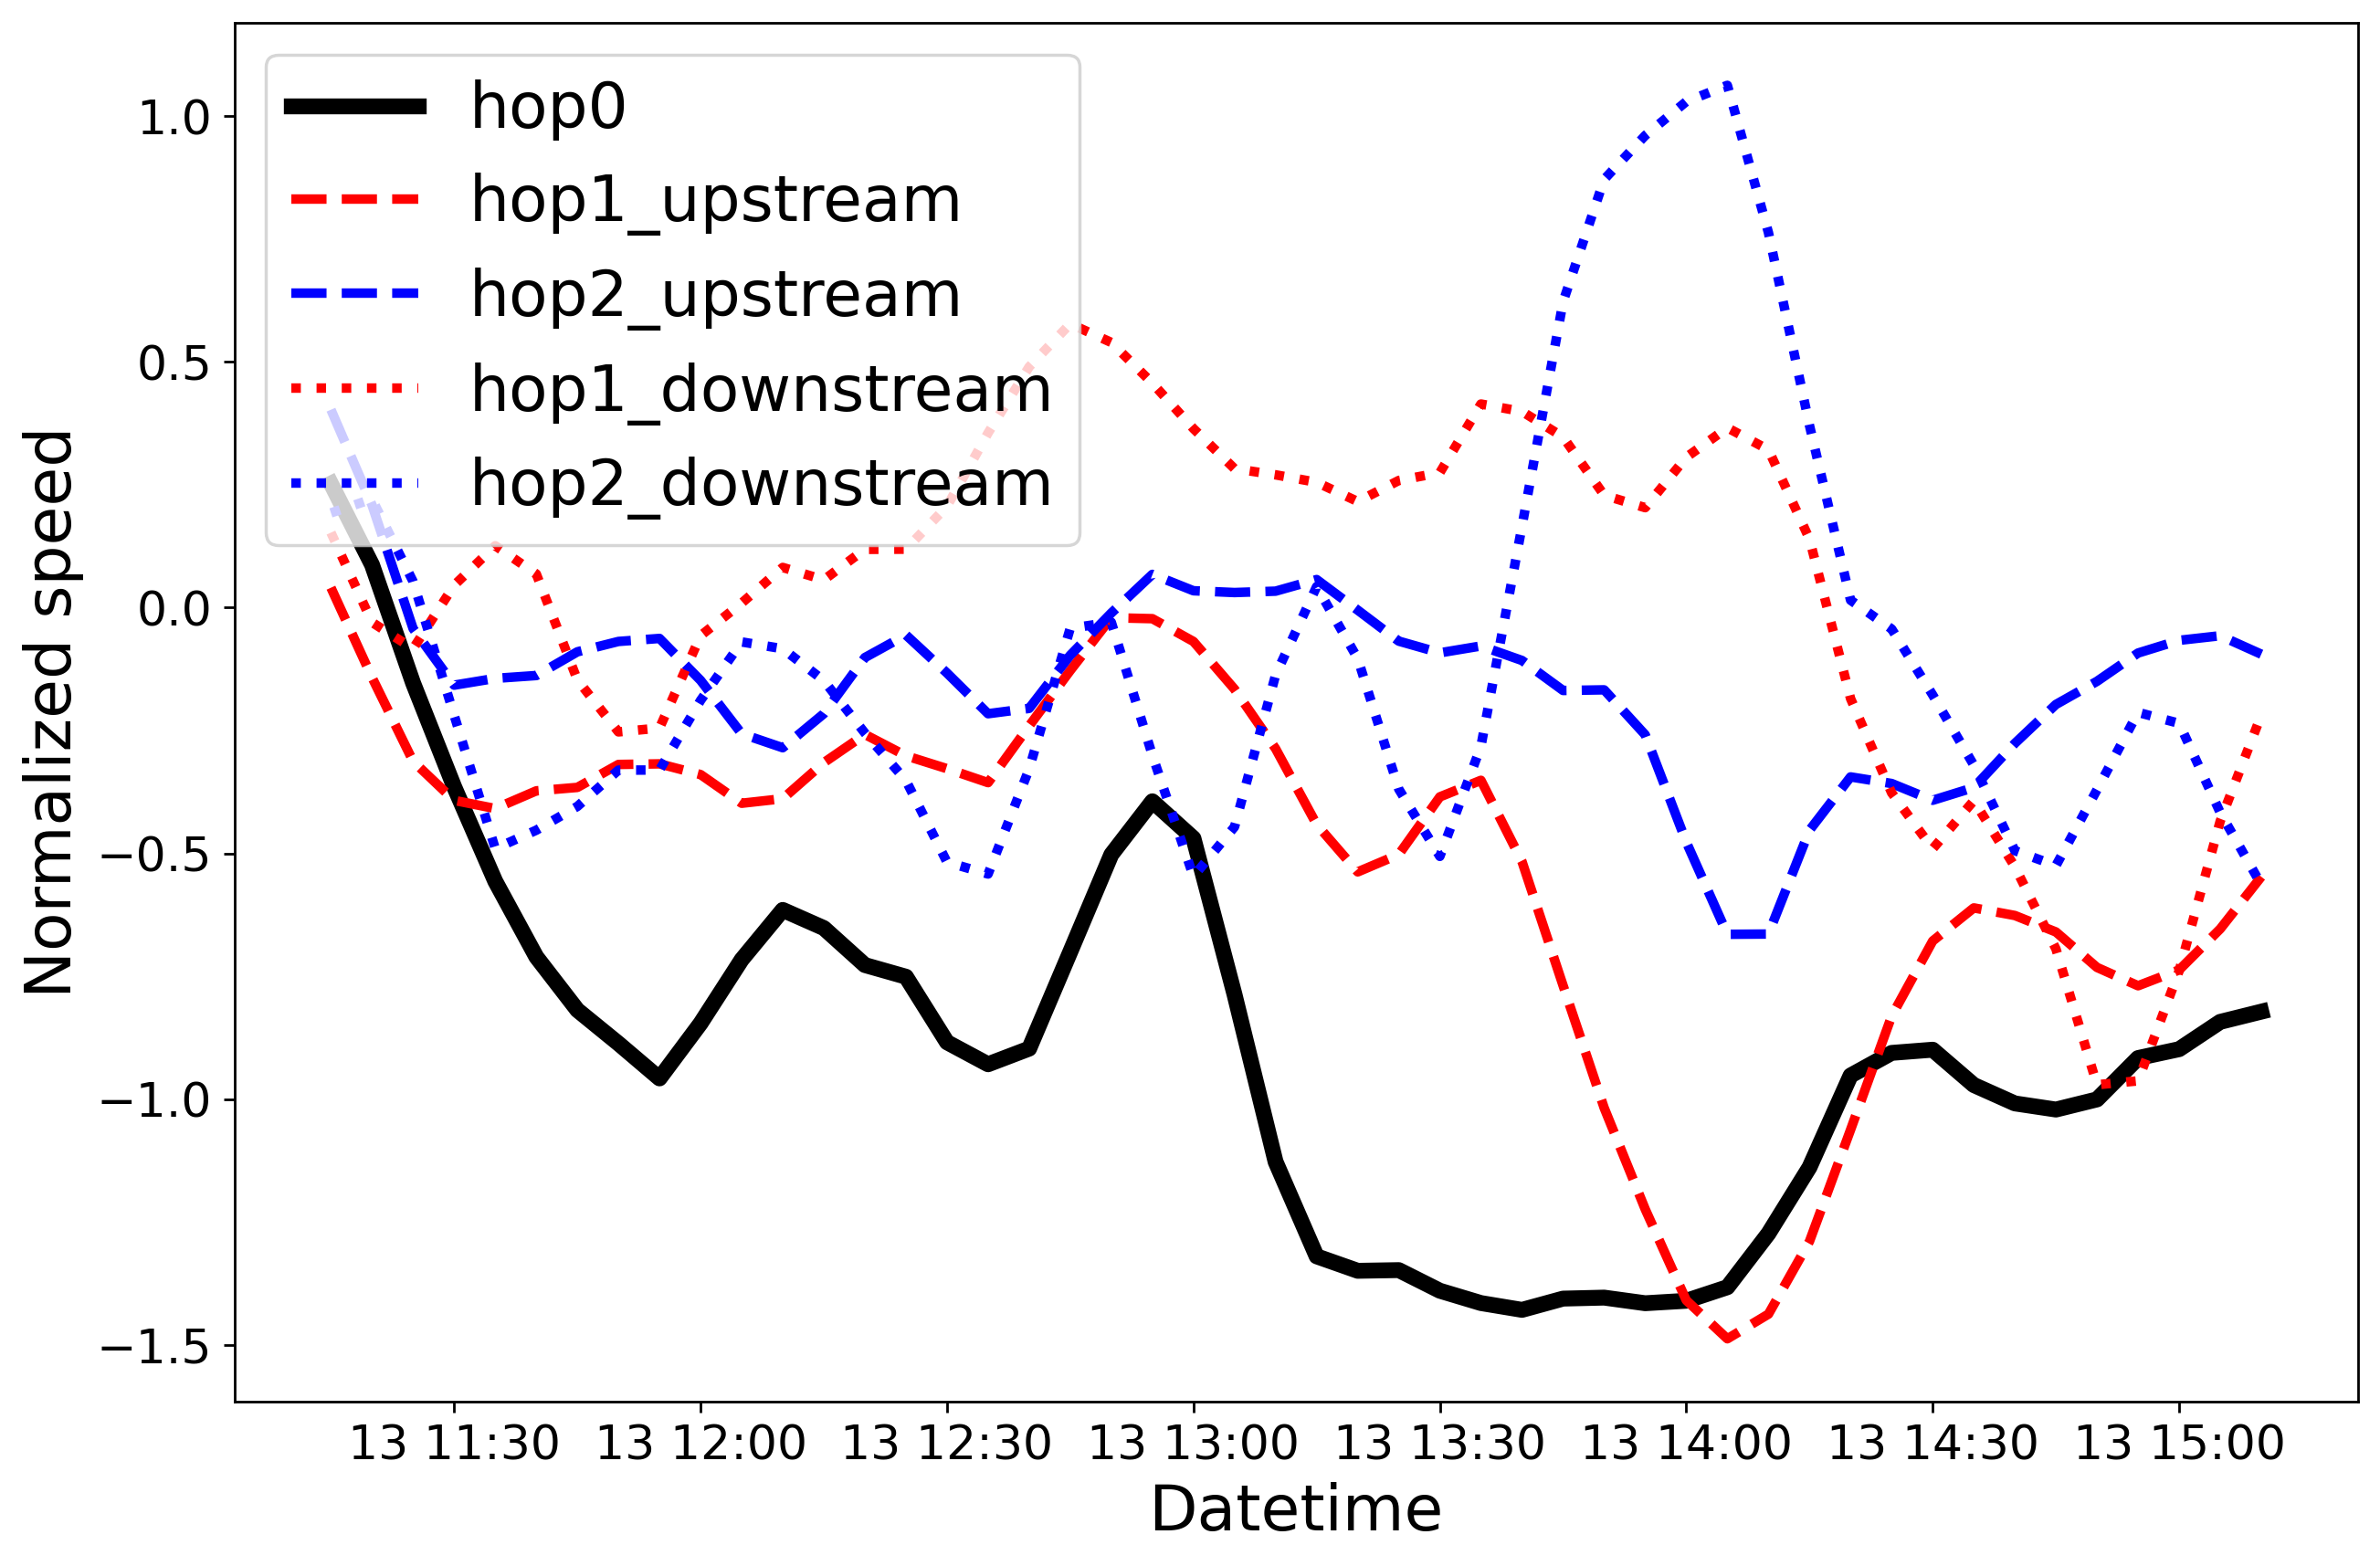

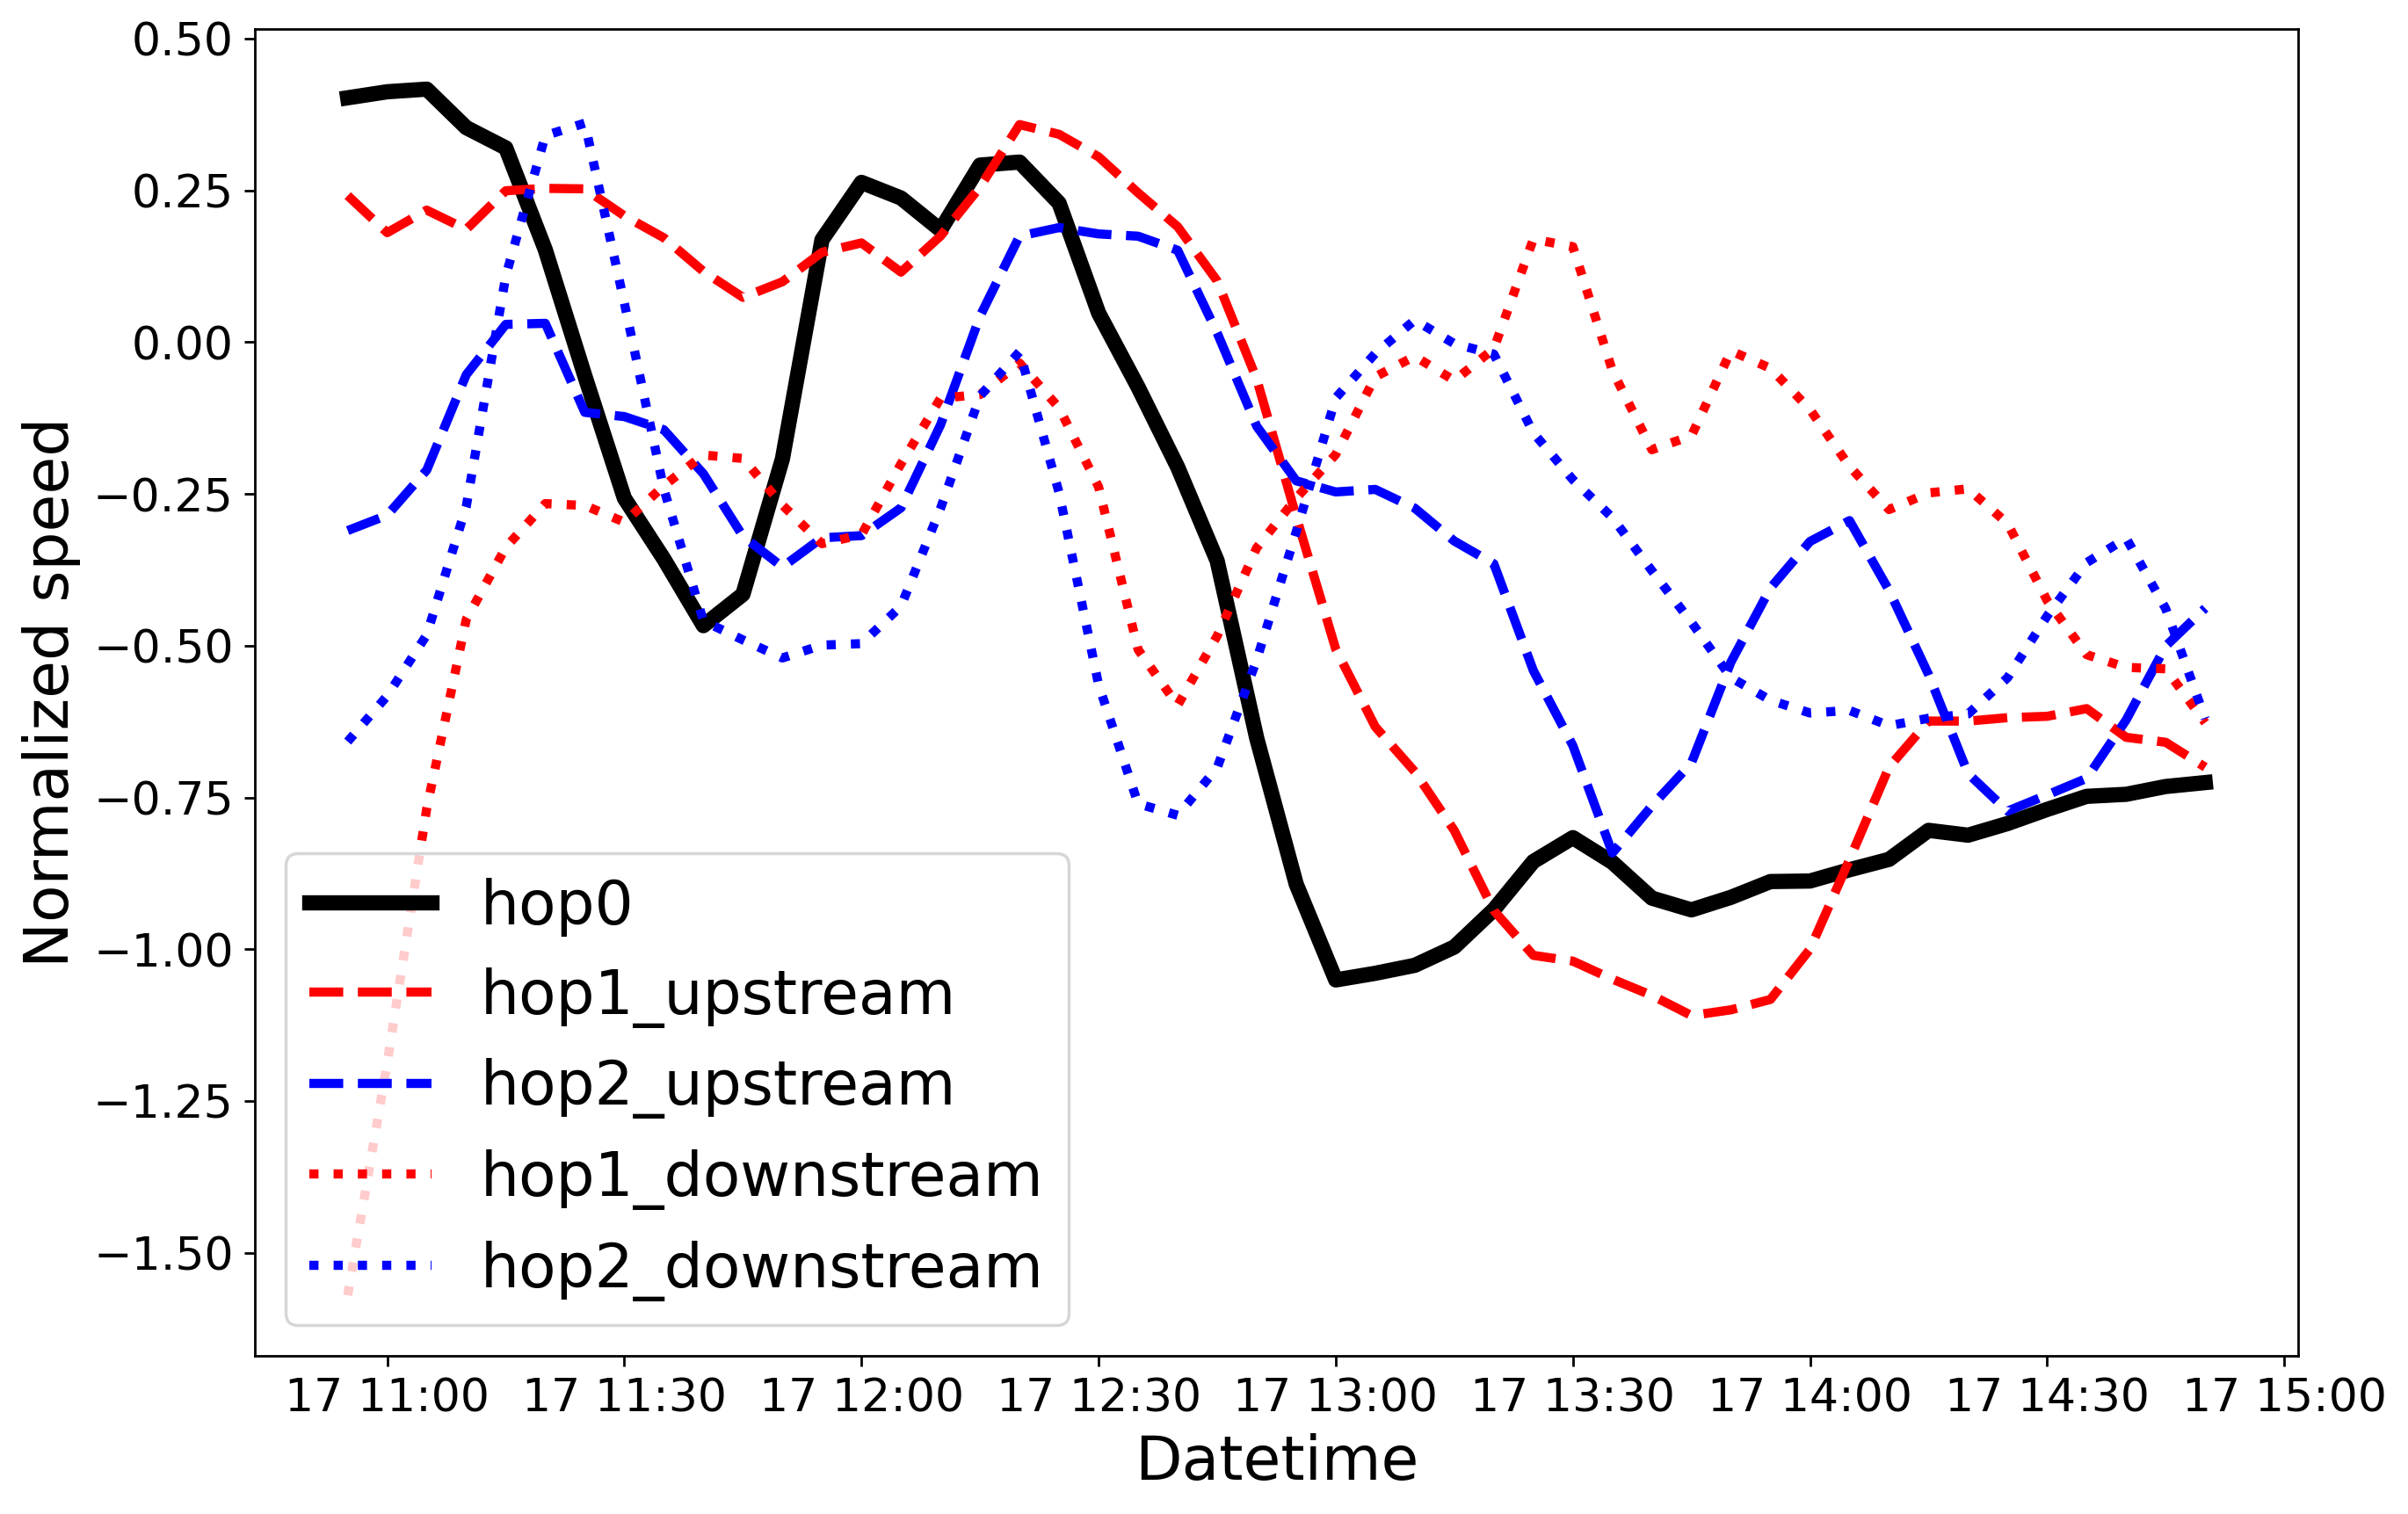

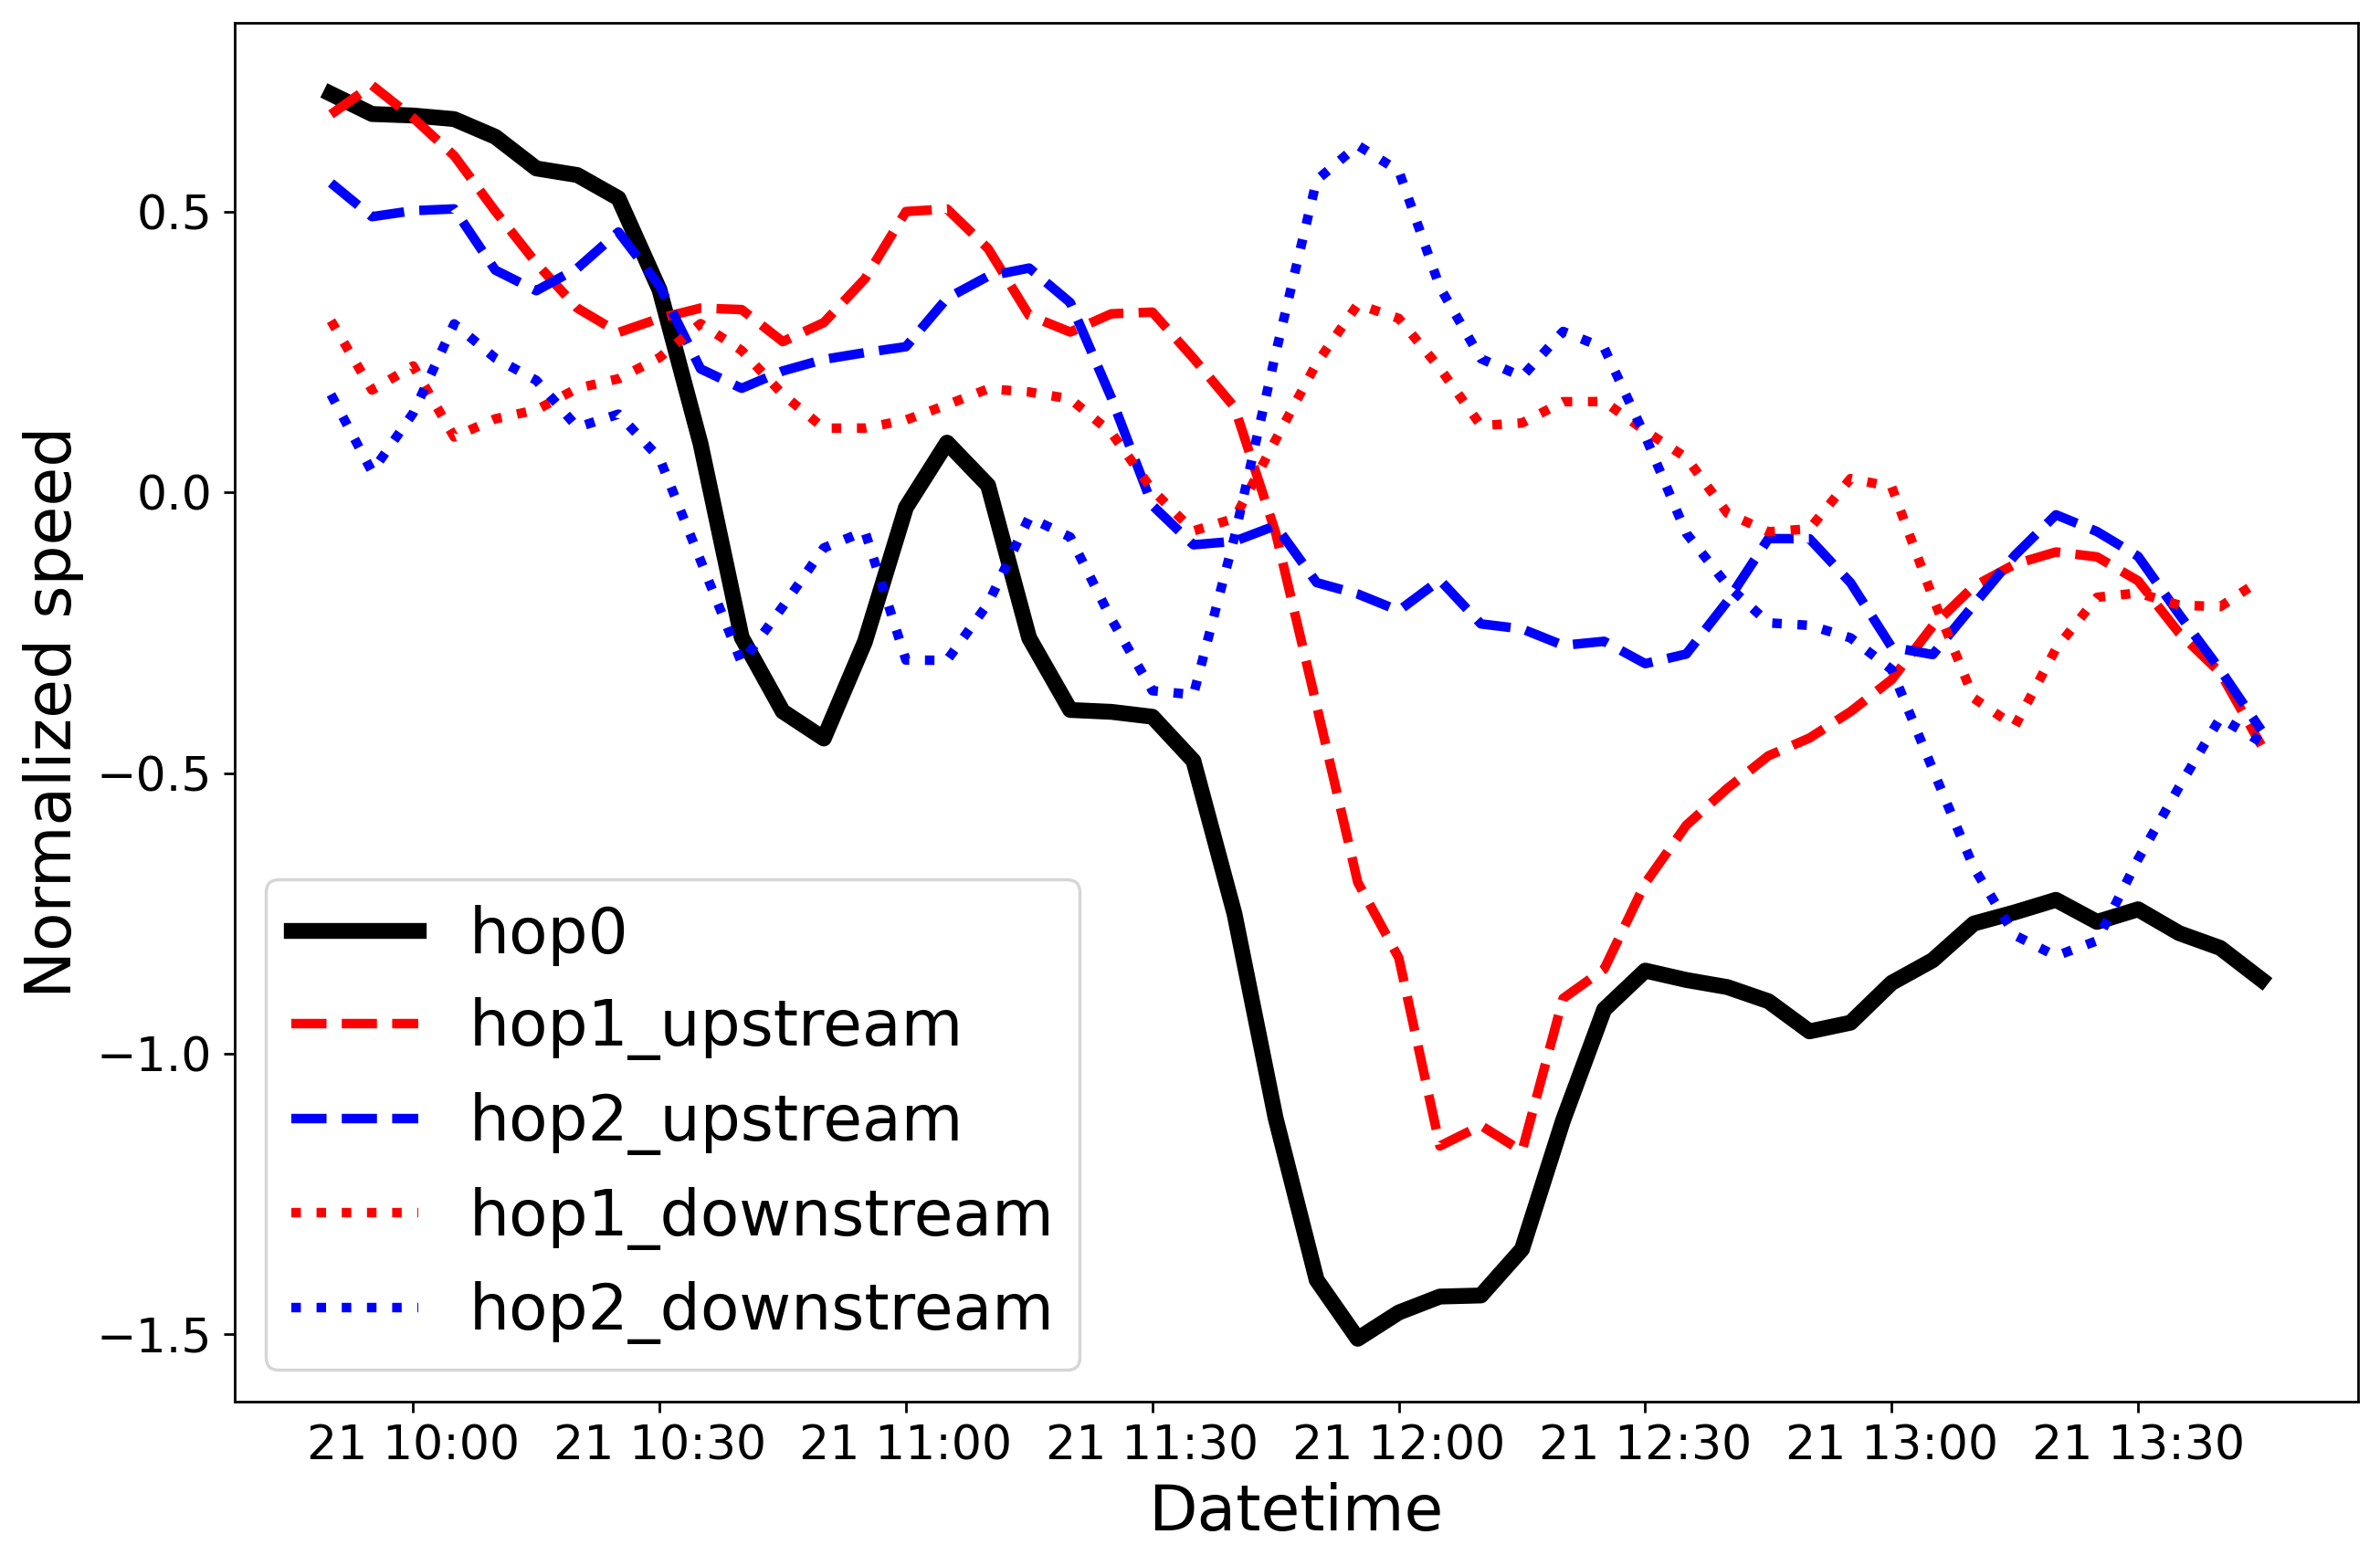

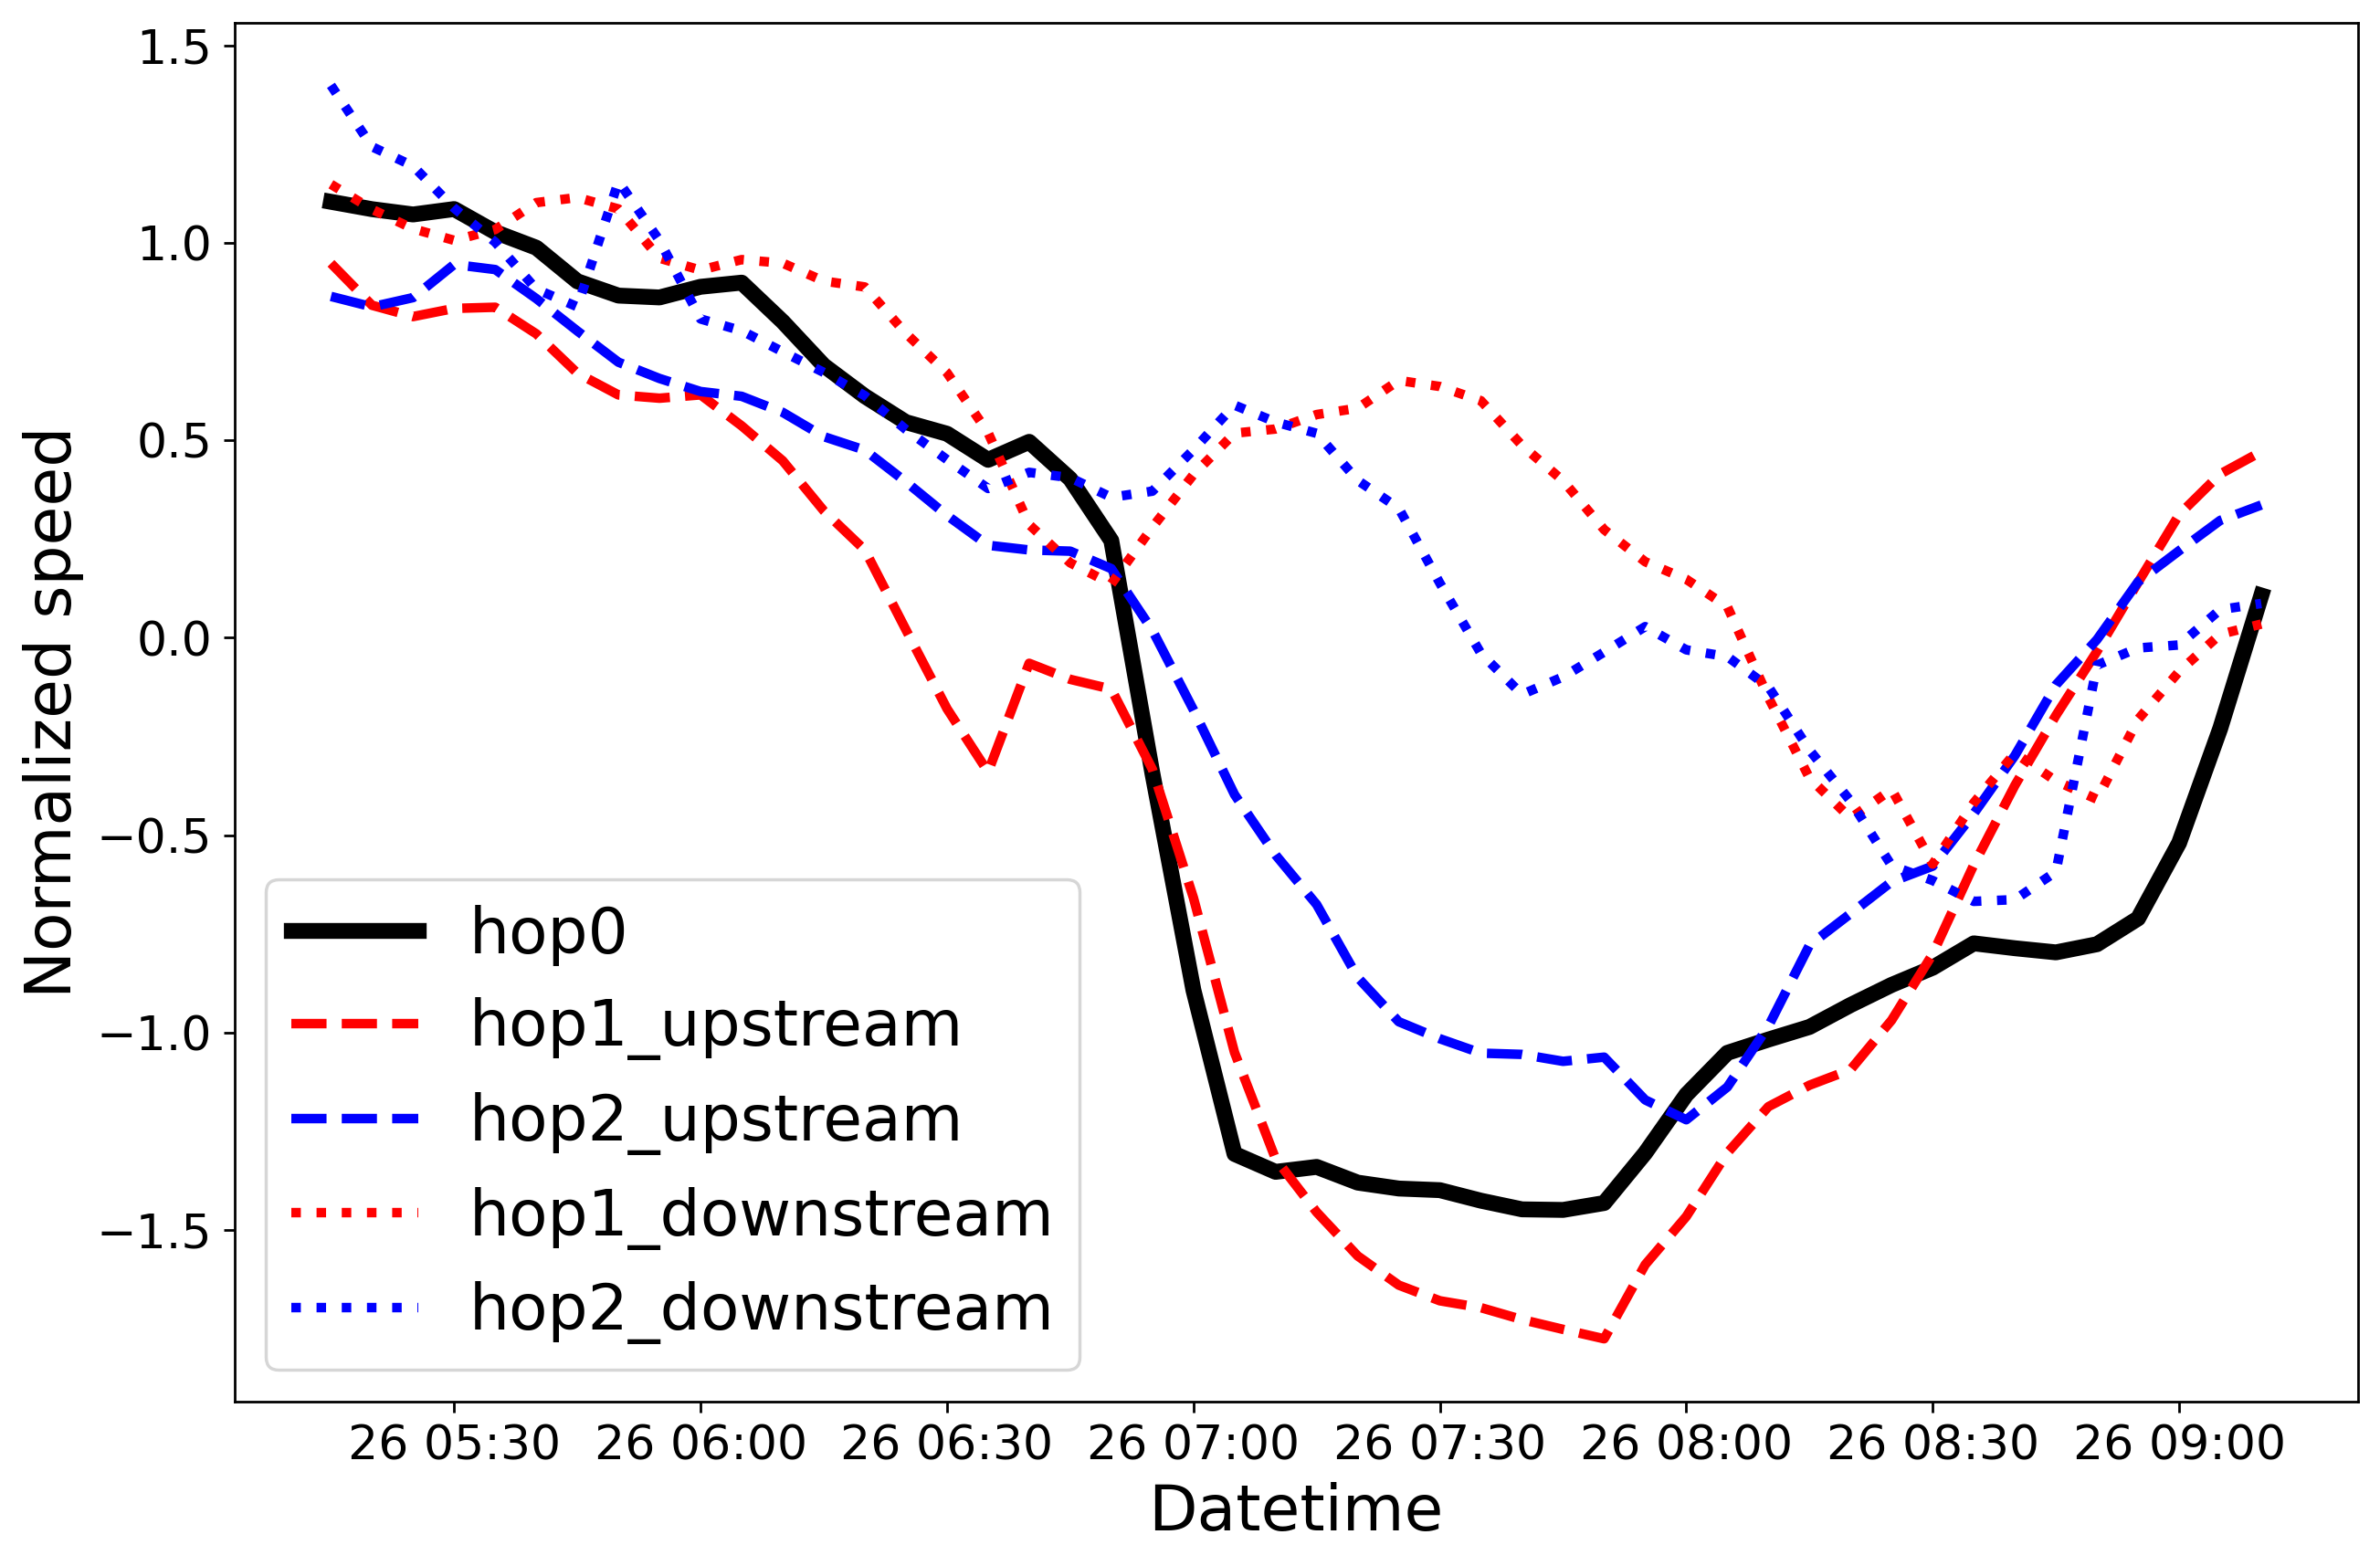

In [19]:
for ix, row in accident_case.iterrows():
    t = datetime.strptime(row['created'], '%Y-%m-%d %H:%M:%S')
    # if (t.month != 12) and (t.month != 1):
    #     continue
    if (t.month > 2):
        continue
    print(t)
    
    t0 = (df_all_norm.index > t+timedelta(minutes=-120))
    t1 = (df_all_norm.index <= t+timedelta(minutes=120))
    plt.figure(figsize=(12, 8))
    plt.plot(df_agg_inflow[t0&t1][0], label='hop0', color='k', lw=5, ls='solid')
    plt.plot(df_agg_inflow[t0&t1][1], label='hop1_upstream',lw=3, ls='dashed', color='r')
    plt.plot(df_agg_inflow[t0&t1][2], label='hop2_upstream', lw=3, ls='dashed', color='b')
    plt.plot(df_agg_outflow[t0&t1][1], label='hop1_downstream',lw=3, ls='dotted', color='r')
    plt.plot(df_agg_outflow[t0&t1][2], label='hop2_downstream',lw=3, ls='dotted', color='b')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(prop={'size':20})
    # plt.title('Non-recurrent Congestion Example', size=18)
    plt.xlabel('Datetime', size=20)
    plt.ylabel('Normalized speed', size=20)
    plt.legend(fontsize=20)

    # plt.rcParams['figure.dpi'] = 250

2021-02-26 07:10:00


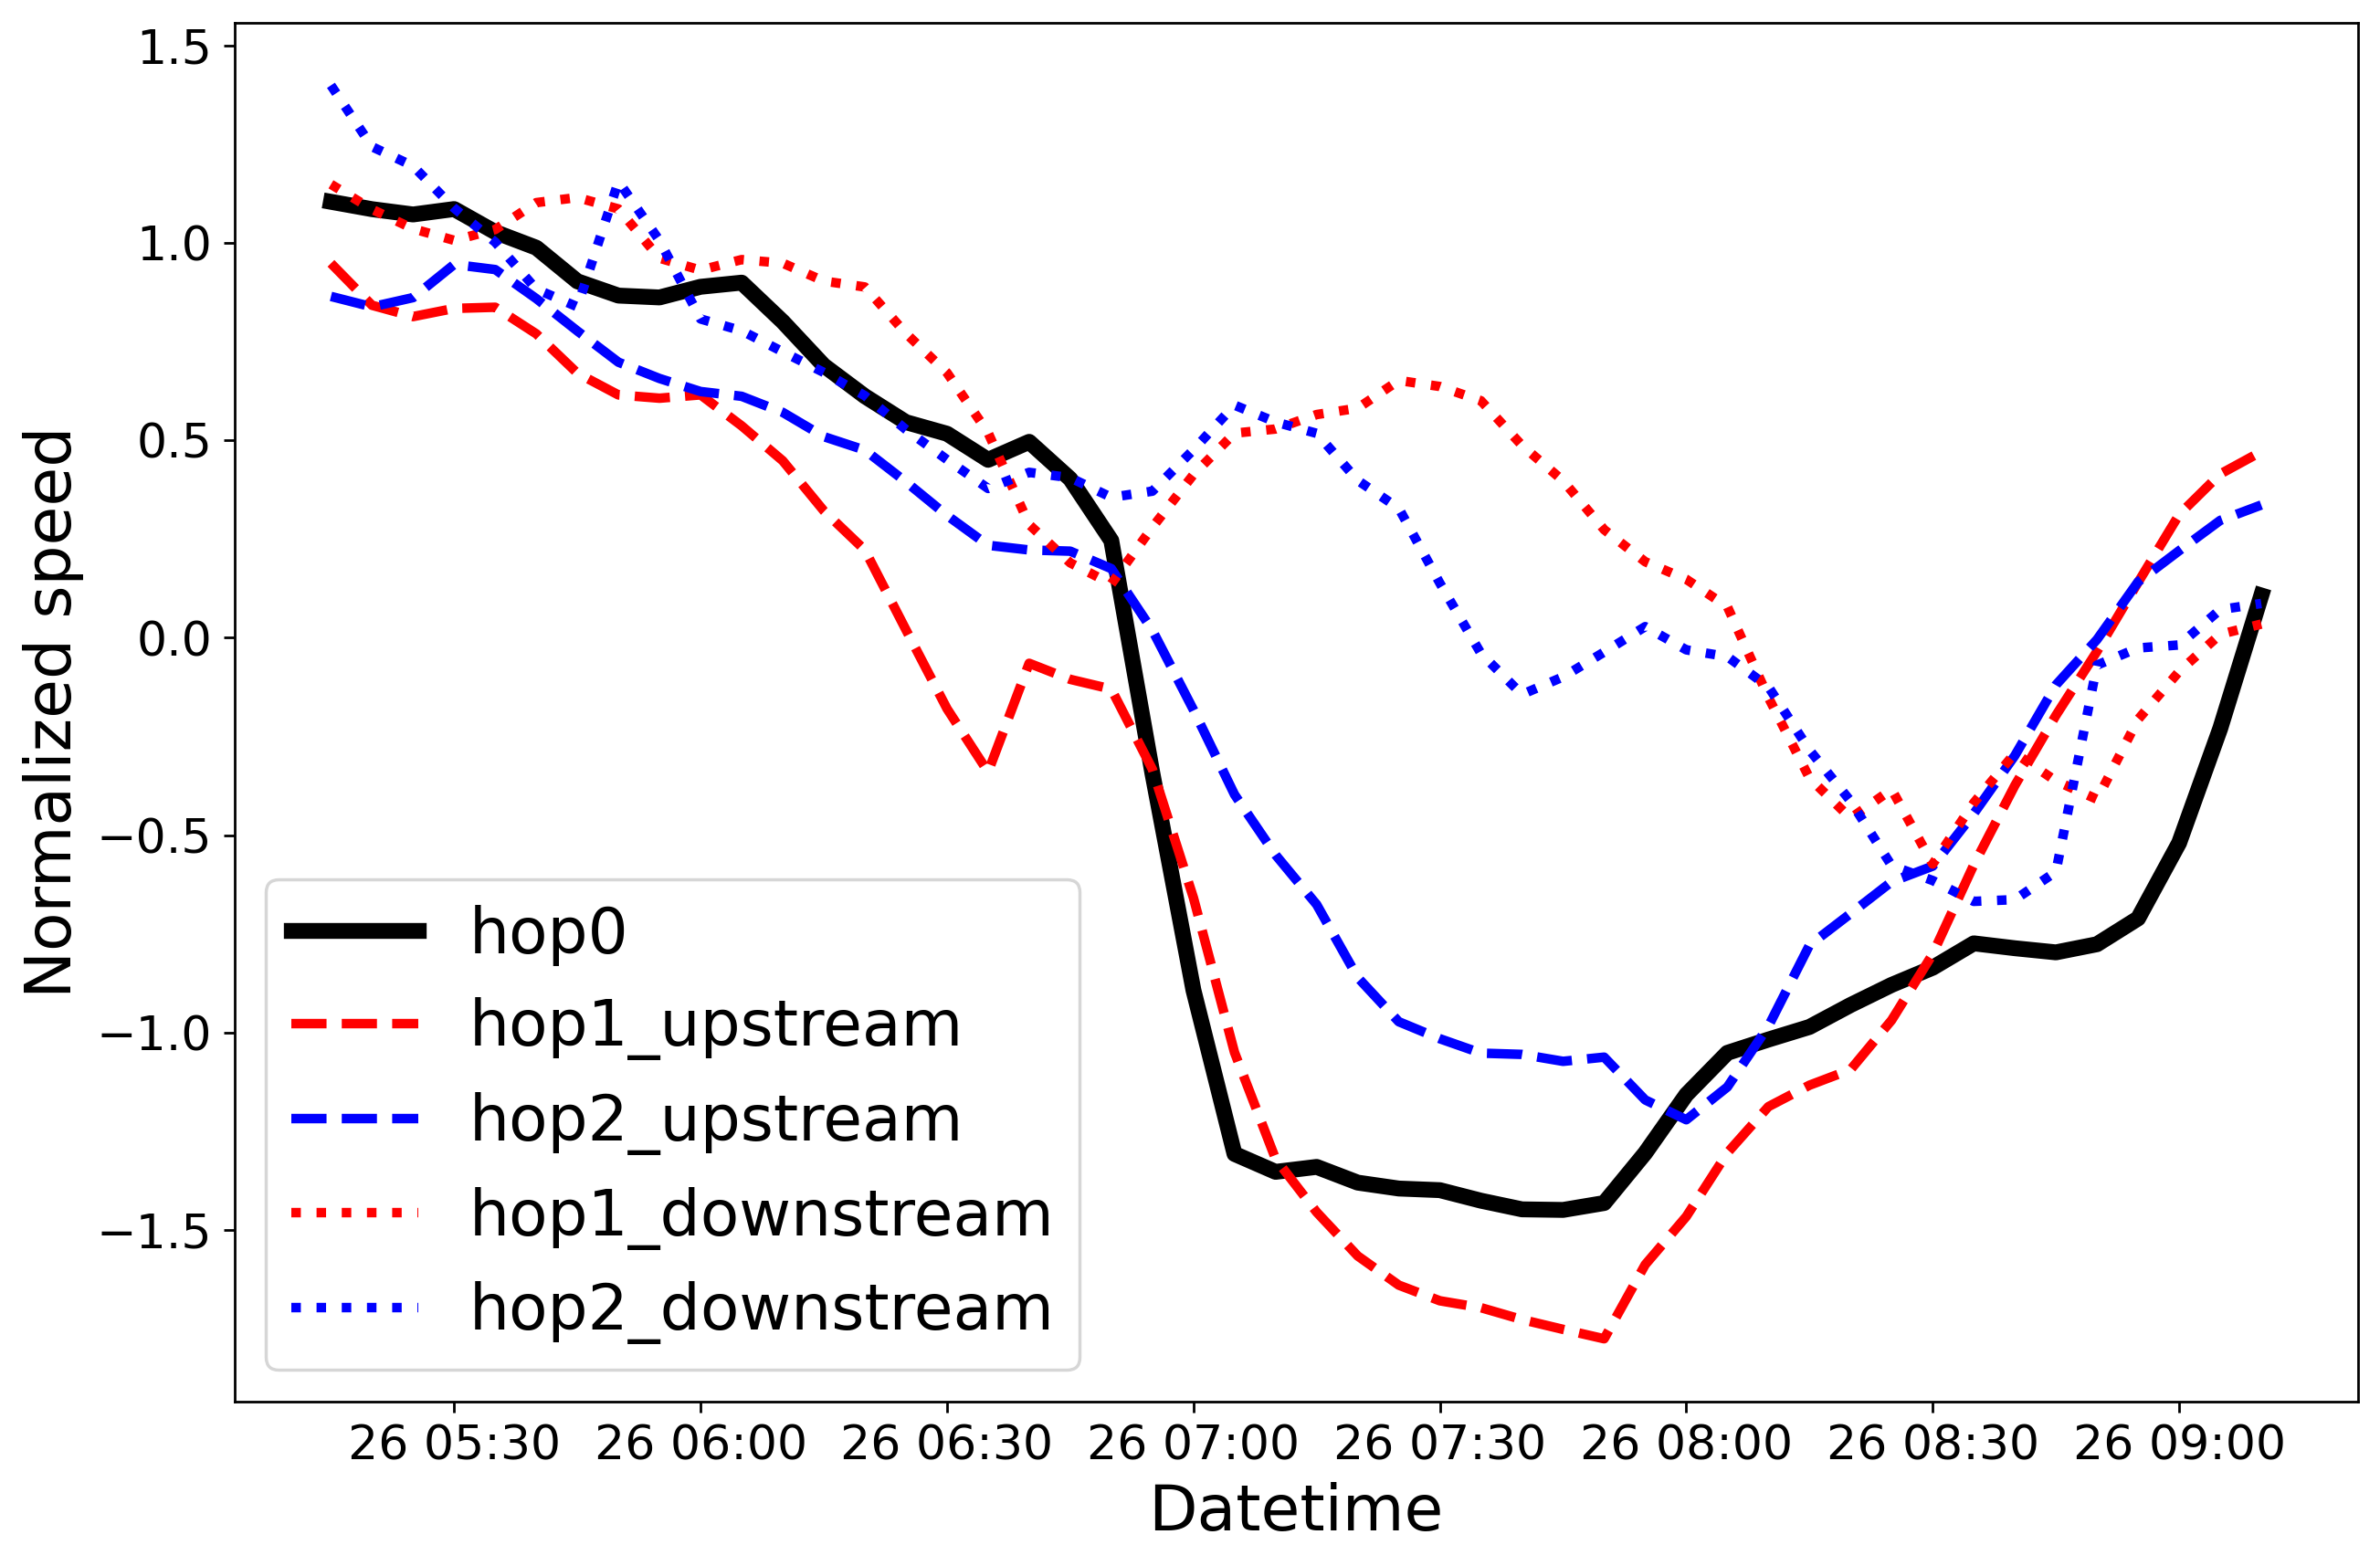

In [24]:
for ix, row in accident_case.iloc[-1:].iterrows():
    t = datetime.strptime(row['created'], '%Y-%m-%d %H:%M:%S')
    # if (t.month != 12) and (t.month != 1):
    #     continue
    if (t.month > 2):
        continue
    print(t)
    
    t0 = (df_all_norm.index > t+timedelta(minutes=-120))
    t1 = (df_all_norm.index <= t+timedelta(minutes=120))
    plt.figure(figsize=(12, 8))
    plt.plot(df_agg_inflow[t0&t1][0], label='hop0', color='k', lw=5, ls='solid')
    plt.plot(df_agg_inflow[t0&t1][1], label='hop1_upstream',lw=3, ls='dashed', color='r')
    plt.plot(df_agg_inflow[t0&t1][2], label='hop2_upstream', lw=3, ls='dashed', color='b')
    plt.plot(df_agg_outflow[t0&t1][1], label='hop1_downstream',lw=3, ls='dotted', color='r')
    plt.plot(df_agg_outflow[t0&t1][2], label='hop2_downstream',lw=3, ls='dotted', color='b')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(prop={'size':20})
    # plt.title('Non-recurrent Congestion Example', size=18)
    plt.xlabel('Datetime', size=20)
    plt.ylabel('Normalized speed', size=20)
    plt.legend(fontsize=20)
    plt.savefig('../images/incident_example2.pdf', dpi=250, bbox_inches = 'tight')